In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
from scipy import signal
from scipy.optimize import curve_fit
import subprocess
import shutil

pi = np.pi
clight = 299792458
E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
clight = 299792458

In [33]:
def func_exp_fit(x, a, b, c):
    return a*np.exp(b*x)+c

In [34]:
def get_folders(folders,cwd):
    new_folders = []
    for folder in folders:
        if os.path.isdir(os.path.join(cwd,folder)):
            print(folder)
            new_folders.append(folder)
    return new_folders

In [35]:
working_folder = 'eSR/394/gap/'
home0 = os.getcwd()
home1 = os.path.join(home0,working_folder)
cwd = os.path.join(home0,working_folder)

In [36]:
folders = os.listdir(cwd)
new_folders = get_folders(folders,cwd)
new_folders = np.sort(new_folders)

#get the starting index in the folder name string that represent the substring of current
i_start_current = new_folders[0].find('Idc')+3

#get the starting index in the folder name string that represent the substring of loading angle
i_start_thetaL = new_folders[0].find('ThetaL')+6

current = [float(folder[folder.find('Idc')+3:folder.find('Idc')+3+4]) for folder in new_folders]
thetaL = [float(folder[folder.find('ThetaL')+6:folder.find('ThetaL')+6+3]) for folder in new_folders]


0009nmacro1_nBin33_Idc2.50A_ThetaL4.0degree
0002nmacro1_nBin33_Idc2.50A_ThetaL-3.0degree
0001nmacro1_nBin33_Idc2.50A_ThetaL-4.0degree
0005nmacro1_nBin33_Idc2.50A_ThetaL0.0degree
0007nmacro1_nBin33_Idc2.50A_ThetaL2.0degree
0006nmacro1_nBin33_Idc2.50A_ThetaL1.0degree
0008nmacro1_nBin33_Idc2.50A_ThetaL3.0degree
0003nmacro1_nBin33_Idc2.50A_ThetaL-2.0degree
0000nmacro1_nBin33_Idc2.50A_ThetaL-5.0degree
0004nmacro1_nBin33_Idc2.50A_ThetaL-1.0degree


In [37]:
inputfile = 'input.txt'
temppath = os.path.join(cwd,new_folders[0])
inputfile = os.path.join(temppath,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])


In [38]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nDynamic = int(tempinput['n_dynamicOn'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
t_rad_long = tempinput['t_rad_long'][0]
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
if nRF ==1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
elif nRF == 2 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0


print(Qs)


0.05410554940716556


0000nmacro1_nBin33_Idc2.50A_ThetaL-5.0degree
The turn number when amplitude reach  100 : 3069.0
[0.03256004 0.11644643 1.56589007]
[[ 1.50768817e-05 -7.03182391e-06 -4.91238506e-04]
 [-7.03182391e-06  3.29214001e-06  2.20271965e-04]
 [-4.91238506e-04  2.20271965e-04  4.49084024e-02]]
The turn number when amplitude reach  100 : 3185.0
[ 5.37929921e+01  6.17586125e-03 -6.23022876e+01]
[[ 6.67867450e+01 -4.60207083e-03 -7.40262660e+01]
 [-4.60207083e-03  3.19488070e-07  5.07494563e-03]
 [-7.40262660e+01  5.07494563e-03  8.25181765e+01]]


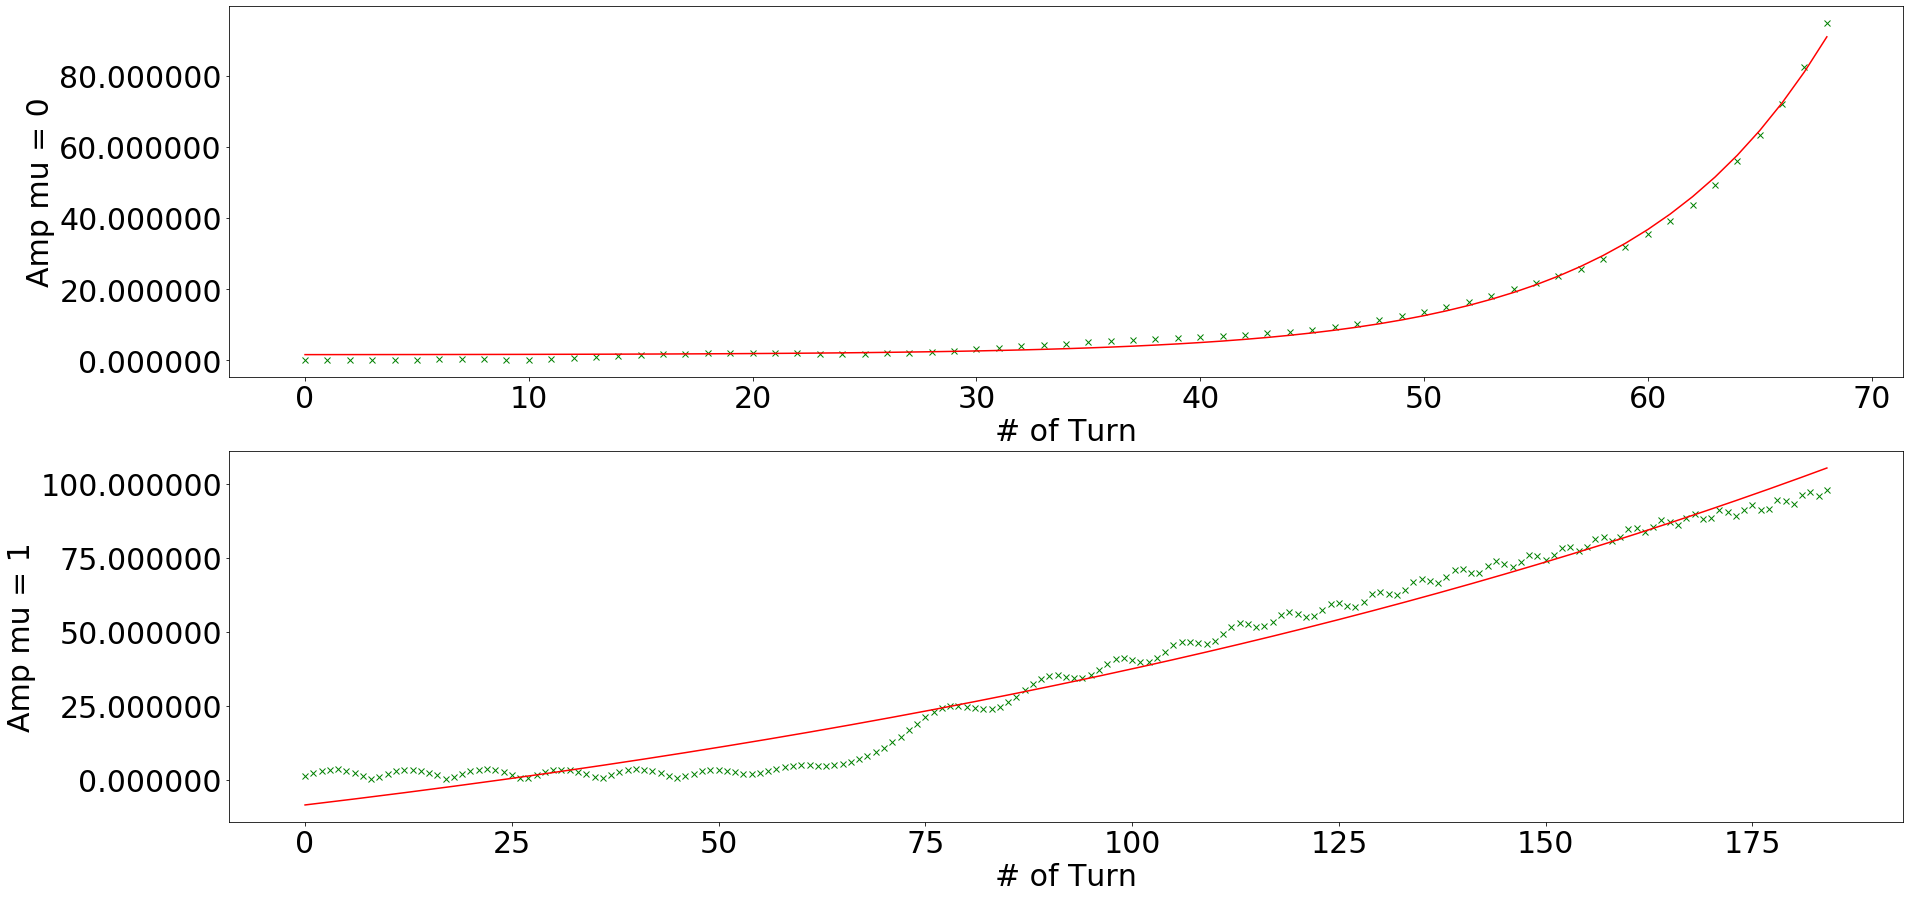

0001nmacro1_nBin33_Idc2.50A_ThetaL-4.0degree
The turn number when amplitude reach  100 : 3076.0
[0.01297014 0.11852786 1.63979392]
[[ 2.89523443e-06 -3.07103596e-06 -1.91323146e-04]
 [-3.07103596e-06  3.26762145e-06  1.95430558e-04]
 [-1.91323146e-04  1.95430558e-04  4.10892634e-02]]
The turn number when amplitude reach  100 : 3192.0
[ 4.04948117e+01  7.03519436e-03 -4.86893837e+01]
[[ 3.30493653e+01 -3.17870660e-03 -3.81002100e+01]
 [-3.17870660e-03  3.08394177e-07  3.63798007e-03]
 [-3.81002100e+01  3.63798007e-03  4.43745903e+01]]


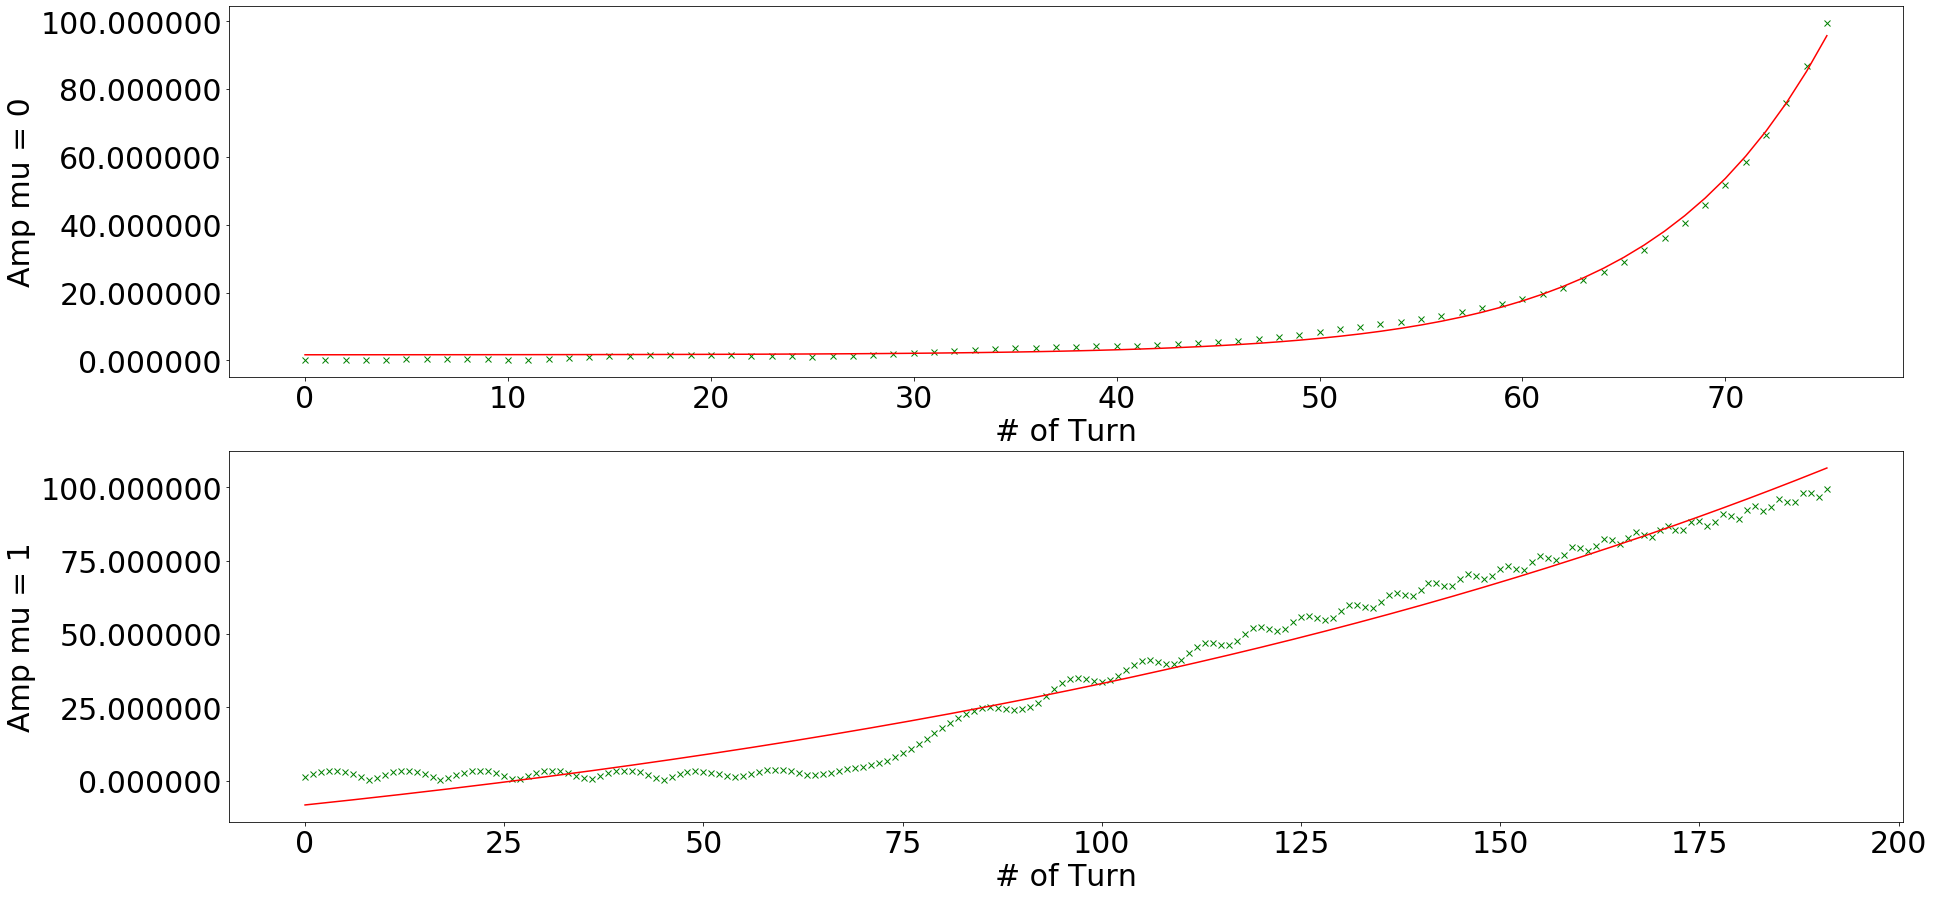

0002nmacro1_nBin33_Idc2.50A_ThetaL-3.0degree
The turn number when amplitude reach  100 : 3085.0
[0.00638704 0.11303497 1.38893574]
[[ 6.50697931e-07 -1.25093336e-06 -6.77040169e-05]
 [-1.25093336e-06  2.41147234e-06  1.25479800e-04]
 [-6.77040169e-05  1.25479800e-04  2.48724322e-02]]
The turn number when amplitude reach  100 : 3204.0
[ 3.09642603e+01  7.69271397e-03 -3.89871260e+01]
[[ 1.78821414e+01 -2.26796804e-03 -2.16158442e+01]
 [-2.26796804e-03  2.90445620e-07  2.71487378e-03]
 [-2.16158442e+01  2.71487378e-03  2.65806554e+01]]


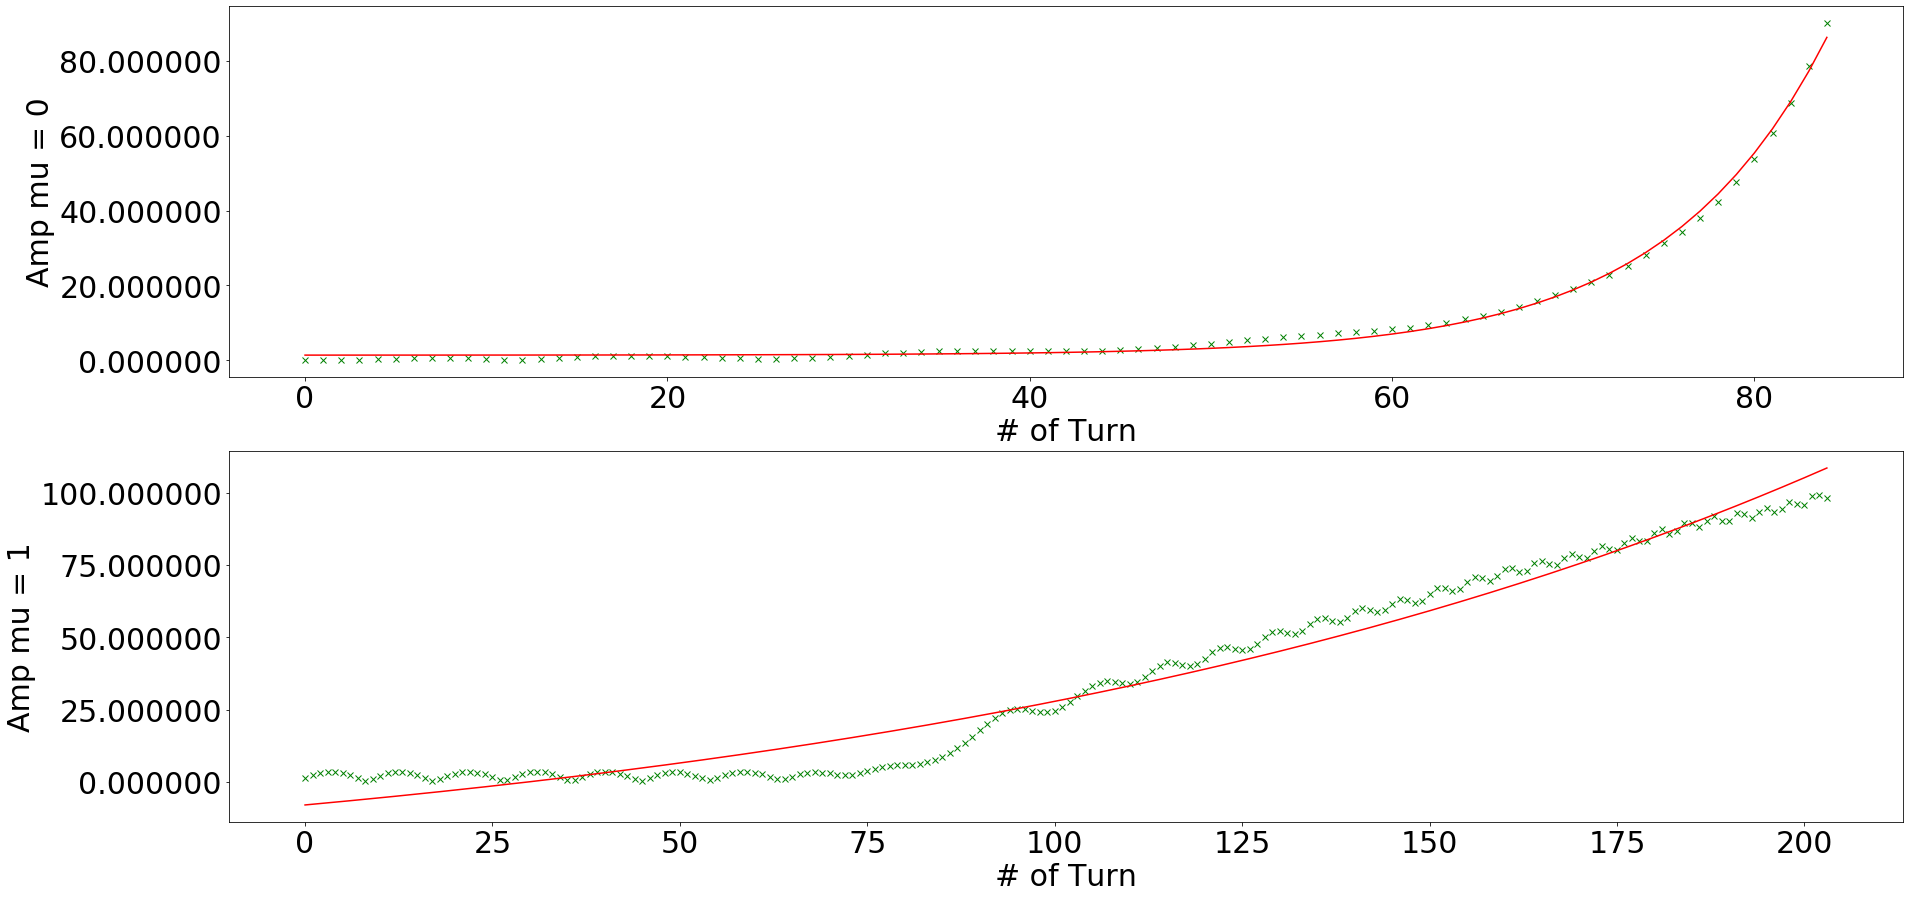

0003nmacro1_nBin33_Idc2.50A_ThetaL-2.0degree
The turn number when amplitude reach  100 : 3102.0
[1.00382706e-03 1.12490635e-01 1.24196949e+00]
[[ 2.02167060e-08 -2.05159618e-07 -9.07484908e-06]
 [-2.05159618e-07  2.08604169e-06  8.90901766e-05]
 [-9.07484908e-06  8.90901766e-05  1.80097025e-02]]
The turn number when amplitude reach  100 : 3221.0
[ 1.84040263e+01  9.08439711e-03 -2.56144999e+01]
[[ 5.79795844e+00 -1.25534997e-03 -7.84548409e+00]
 [-1.25534997e-03  2.74801654e-07  1.67314968e-03]
 [-7.84548409e+00  1.67314968e-03  1.10370659e+01]]


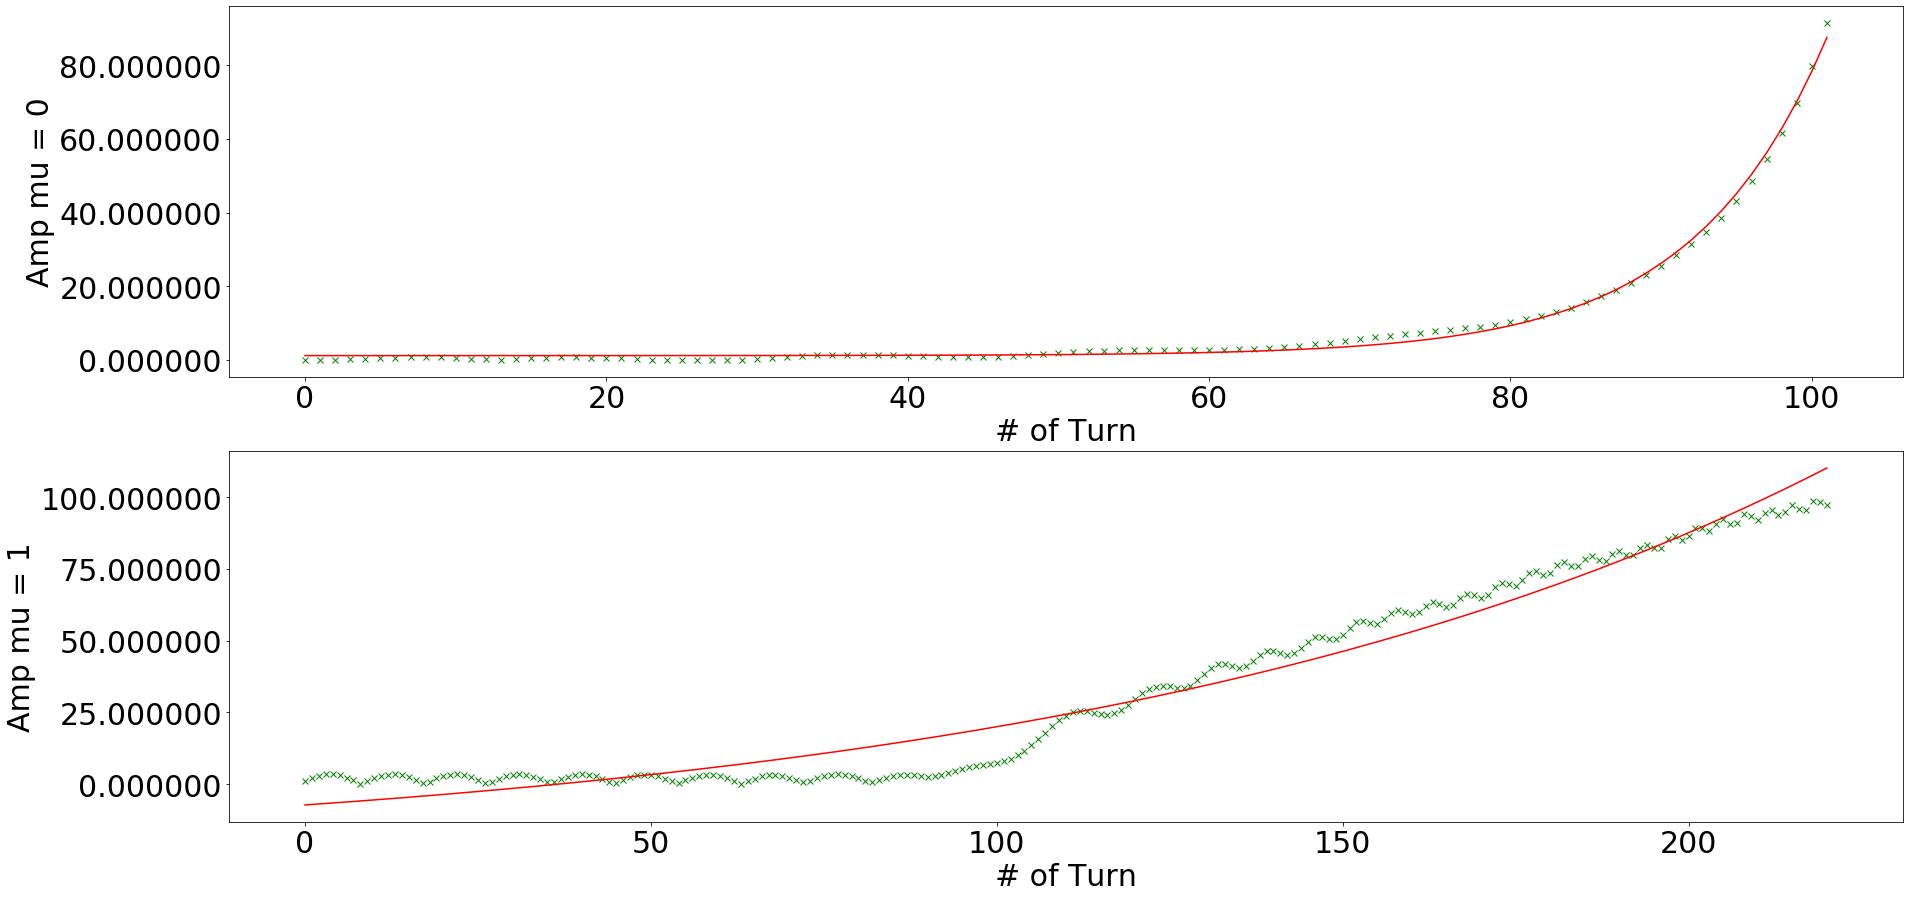

0004nmacro1_nBin33_Idc2.50A_ThetaL-1.0degree
The turn number when amplitude reach  100 : 3185.0
[1.20323501e-07 1.10837760e-01 8.03809611e-01]
[[ 6.62727700e-16 -3.05029591e-11 -6.93927411e-10]
 [-3.05029591e-11  1.40480440e-06  3.12630811e-05]
 [-6.93927411e-10  3.12630811e-05  6.43004800e-03]]
The turn number when amplitude reach  100 : 3301.0
[ 2.4296089   0.01295632 -5.97302282]
[[ 1.02948723e-01 -1.42941758e-04 -2.86438240e-01]
 [-1.42941758e-04  2.00410653e-07  3.84376356e-04]
 [-2.86438240e-01  3.84376356e-04  1.04473396e+00]]


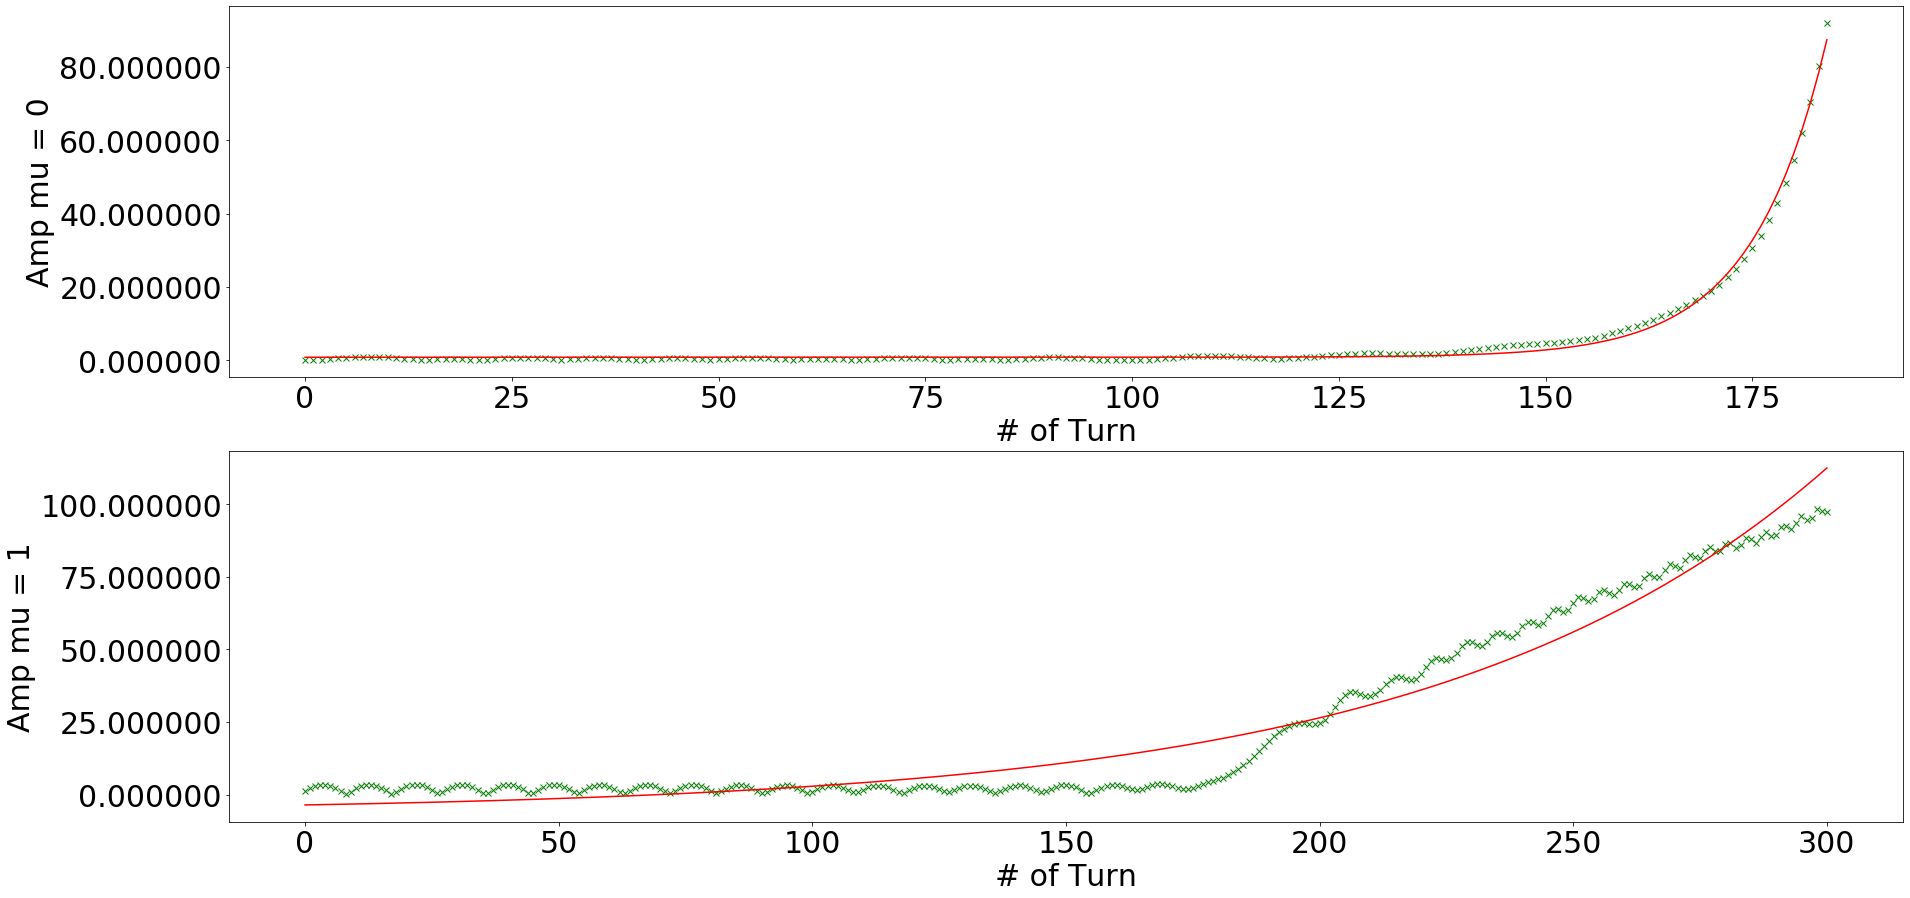

0005nmacro1_nBin33_Idc2.50A_ThetaL0.0degree
The turn number when amplitude reach  100 : 19999.0
[ 0.96729802 -0.0041439   0.08902333]
[[ 1.64187144e-04 -7.03286523e-07 -5.14127065e-09]
 [-7.03286523e-07  6.23371148e-09 -1.06522419e-08]
 [-5.14127065e-09 -1.06522419e-08  6.22915932e-07]]
The turn number when amplitude reach  100 : 19999.0
[ 1.72073530e+00 -7.36328277e-04  6.81079218e-01]
[[ 4.03779572e-04 -1.72753144e-07 -1.96411205e-08]
 [-1.72753144e-07  1.82728856e-10 -2.03066795e-08]
 [-1.96411205e-08 -2.03066795e-08  1.18691159e-05]]


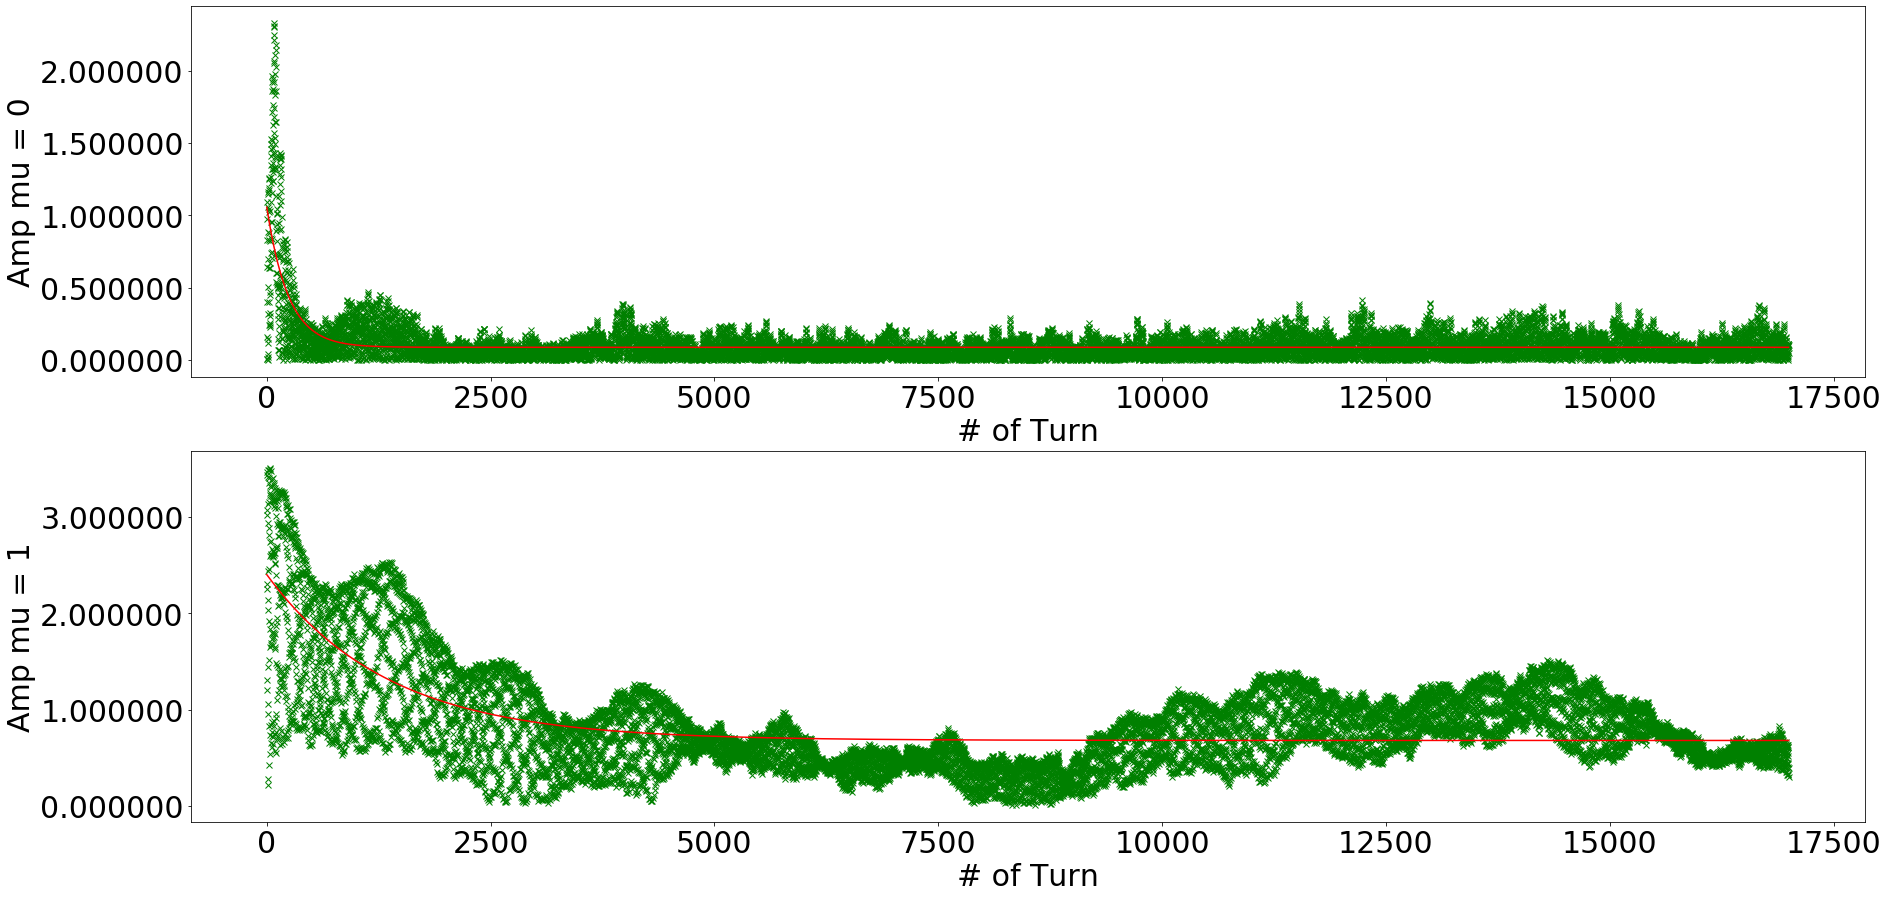

0006nmacro1_nBin33_Idc2.50A_ThetaL1.0degree
The turn number when amplitude reach  100 : 19999.0
[ 1.4064949  -0.00601151  0.08346079]
[[ 1.98600200e-04 -8.48725607e-07 -6.11603966e-09]
 [-8.48725607e-07  7.44846869e-09 -8.72307258e-09]
 [-6.11603966e-09 -8.72307258e-09  5.11757816e-07]]
The turn number when amplitude reach  100 : 19999.0
[ 1.78225278e+00 -7.00310356e-04  5.02597277e-01]
[[ 3.76619389e-04 -1.47957987e-07 -2.05272334e-08]
 [-1.47957987e-07  1.45817933e-10 -1.87364788e-08]
 [-2.05272334e-08 -1.87364788e-08  1.19268825e-05]]


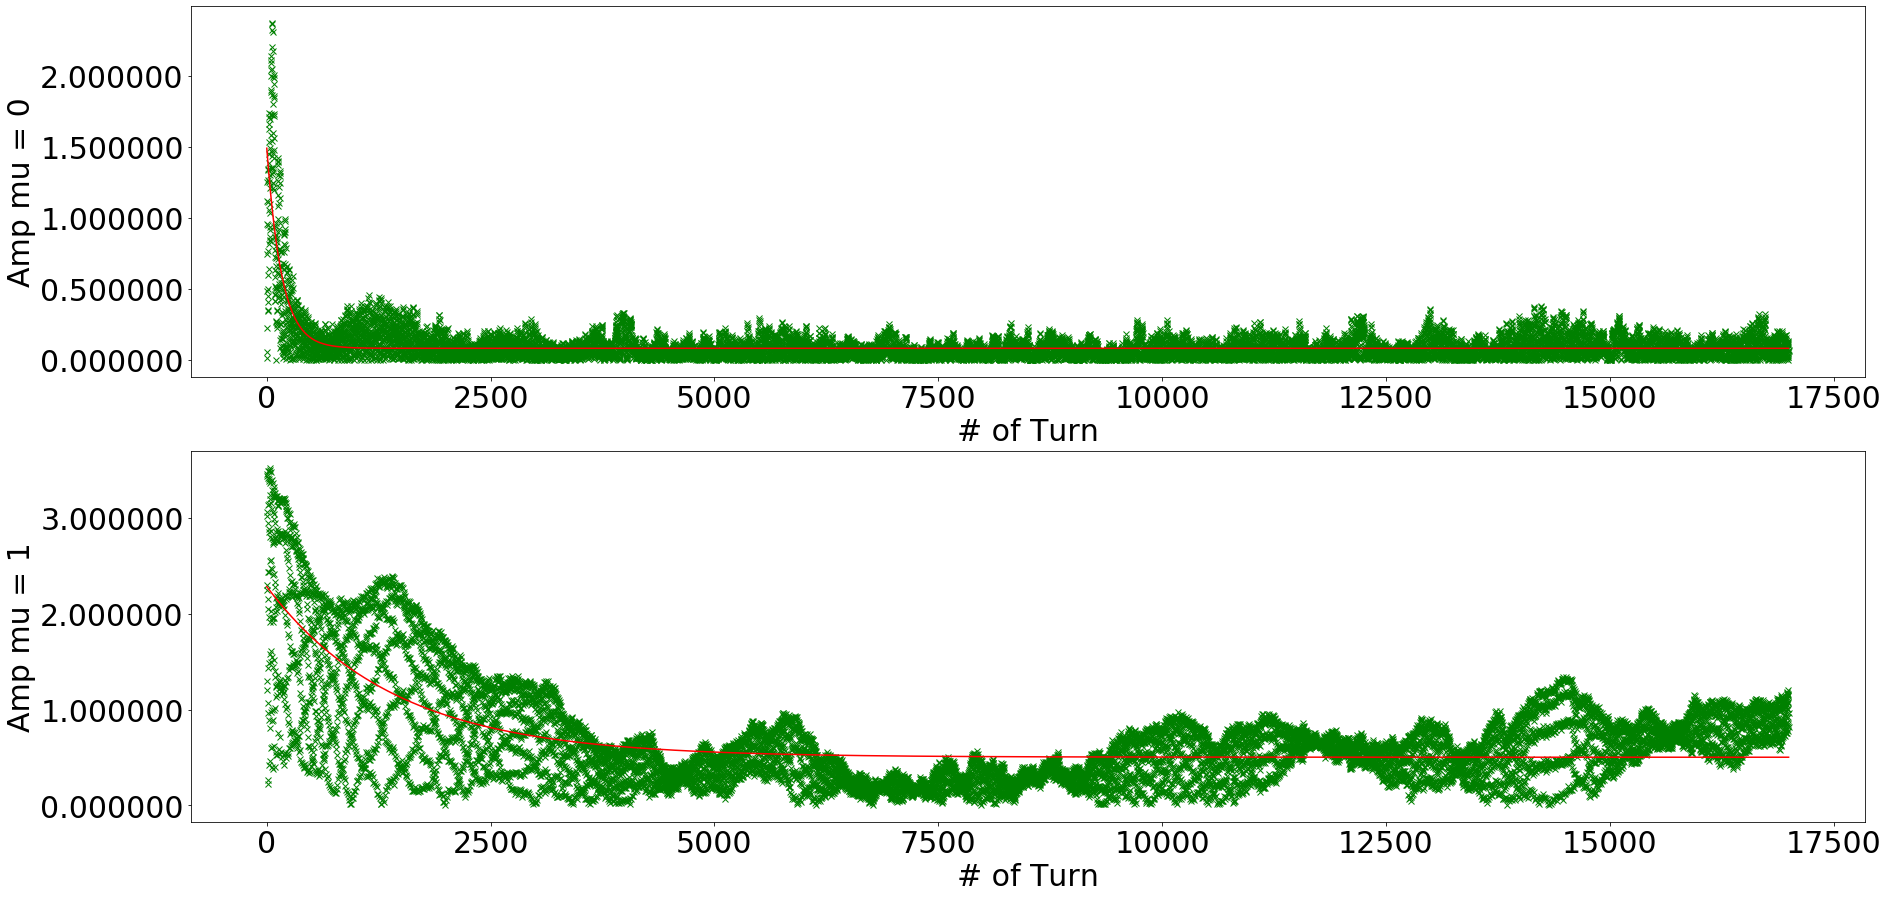

0007nmacro1_nBin33_Idc2.50A_ThetaL2.0degree
The turn number when amplitude reach  100 : 19999.0
[ 1.58437464 -0.00699142  0.07975449]
[[ 2.20500187e-04 -9.72875222e-07 -6.75849122e-09]
 [-9.72875222e-07  8.79804209e-09 -8.56135802e-09]
 [-6.75849122e-09 -8.56135802e-09  4.86728307e-07]]
The turn number when amplitude reach  100 : 19999.0
[ 1.83948324e+00 -5.49104083e-04  4.20612324e-01]
[[ 2.60369350e-04 -7.76611984e-08 -5.35260681e-08]
 [-7.76611984e-08  6.37529416e-11 -1.45372708e-08]
 [-5.35260681e-08 -1.45372708e-08  1.21992001e-05]]


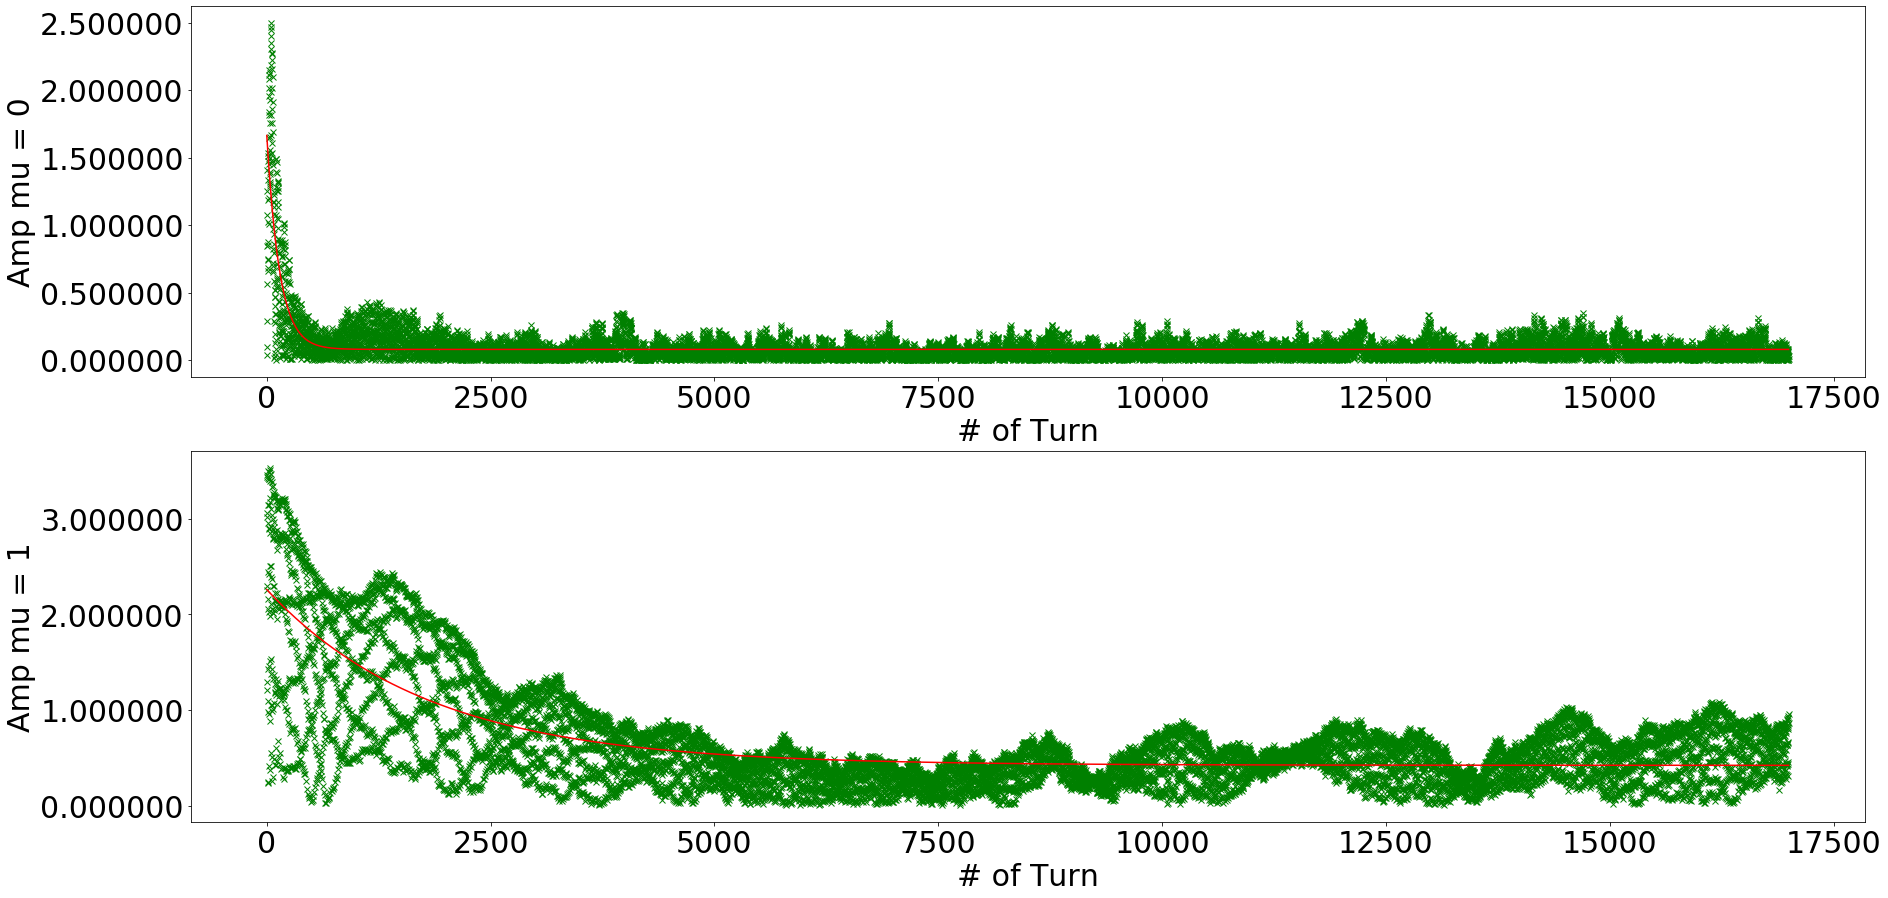

0008nmacro1_nBin33_Idc2.50A_ThetaL3.0degree
The turn number when amplitude reach  100 : 19999.0
[ 1.7300581  -0.00784955  0.07849647]
[[ 2.52784281e-04 -1.14676050e-06 -7.72521028e-09]
 [-1.14676050e-06  1.06515472e-08 -8.96576665e-09]
 [-7.72521028e-09 -8.96576665e-09  4.95952272e-07]]
The turn number when amplitude reach  100 : 19999.0
[ 1.89382408e+00 -4.56853348e-04  3.82572087e-01]
[[ 2.23954160e-04 -5.38296392e-08 -2.06453387e-07]
 [-5.38296392e-08  3.96286210e-11 -1.41436372e-08]
 [-2.06453387e-07 -1.41436372e-08  1.47635132e-05]]


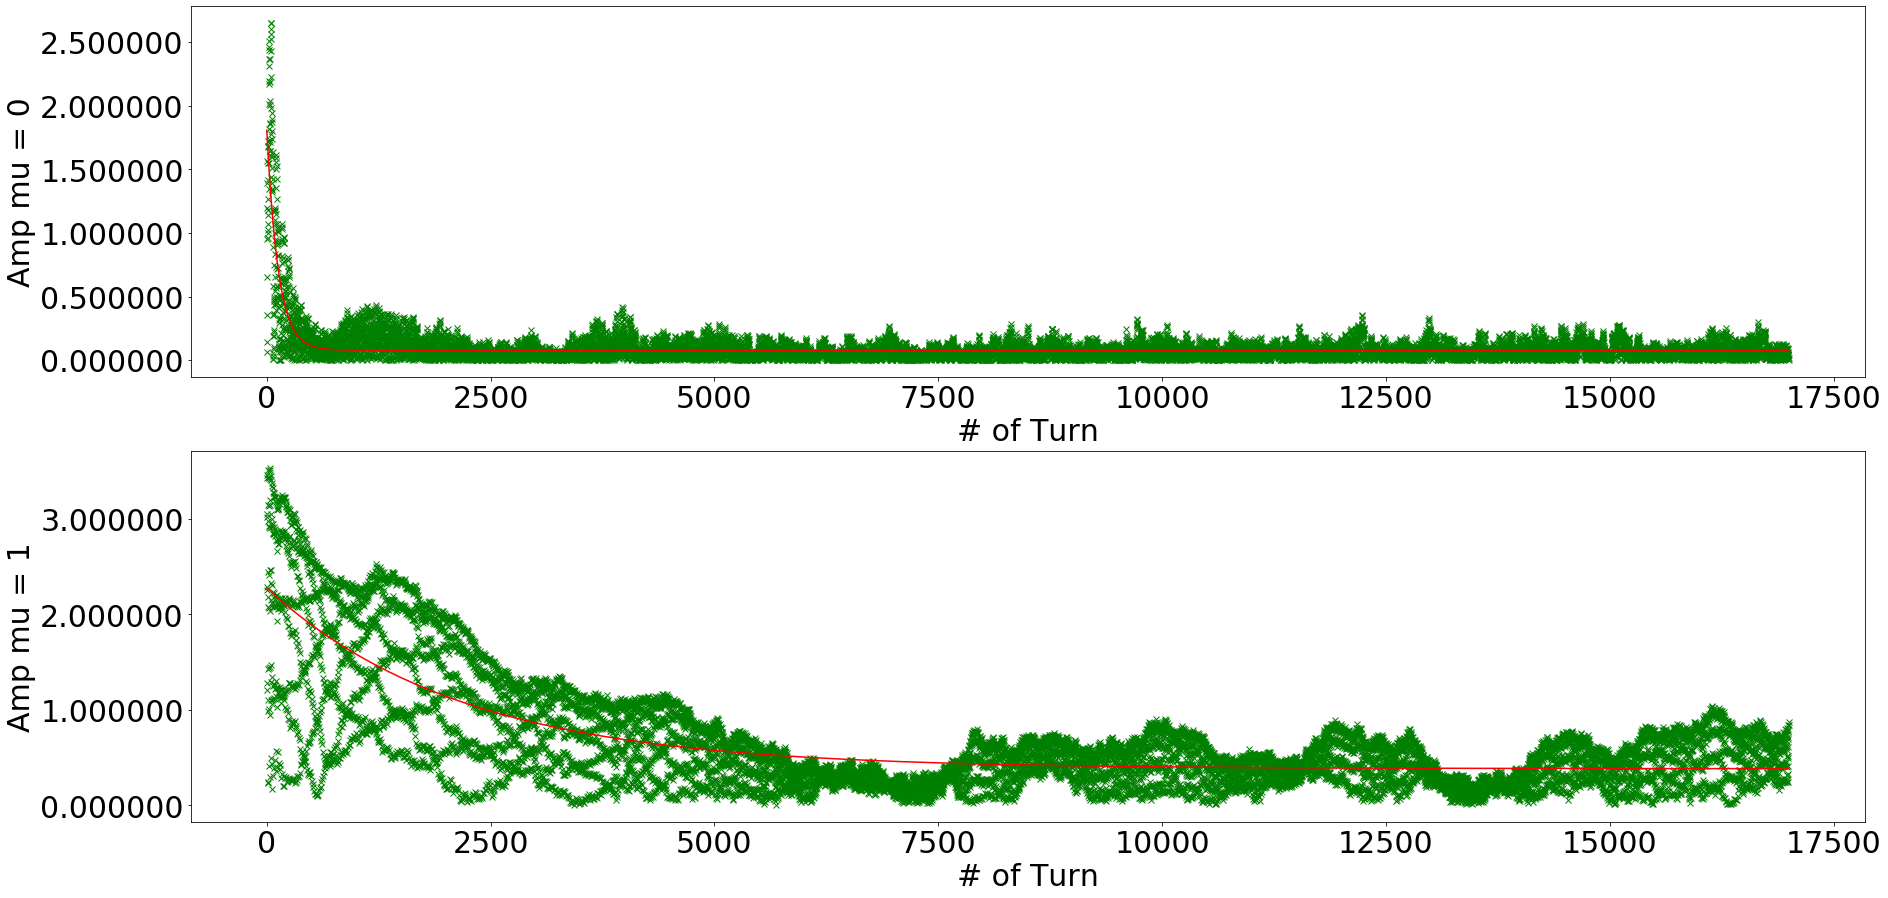

0009nmacro1_nBin33_Idc2.50A_ThetaL4.0degree
The turn number when amplitude reach  100 : 19999.0
[ 1.89359215 -0.00857832  0.07955956]
[[ 2.75400385e-04 -1.24743301e-06 -8.40039897e-09]
 [-1.24743301e-06  1.15618813e-08 -8.91066742e-09]
 [-8.40039897e-09 -8.91066742e-09  4.93841661e-07]]
The turn number when amplitude reach  100 : 19999.0
[ 1.91657086e+00 -3.76035219e-04  3.36407155e-01]
[[ 2.04296810e-04 -3.94156599e-08 -8.75227055e-07]
 [-3.94156599e-08  2.78102855e-11 -1.57419103e-08]
 [-8.75227055e-07 -1.57419103e-08  2.05254056e-05]]


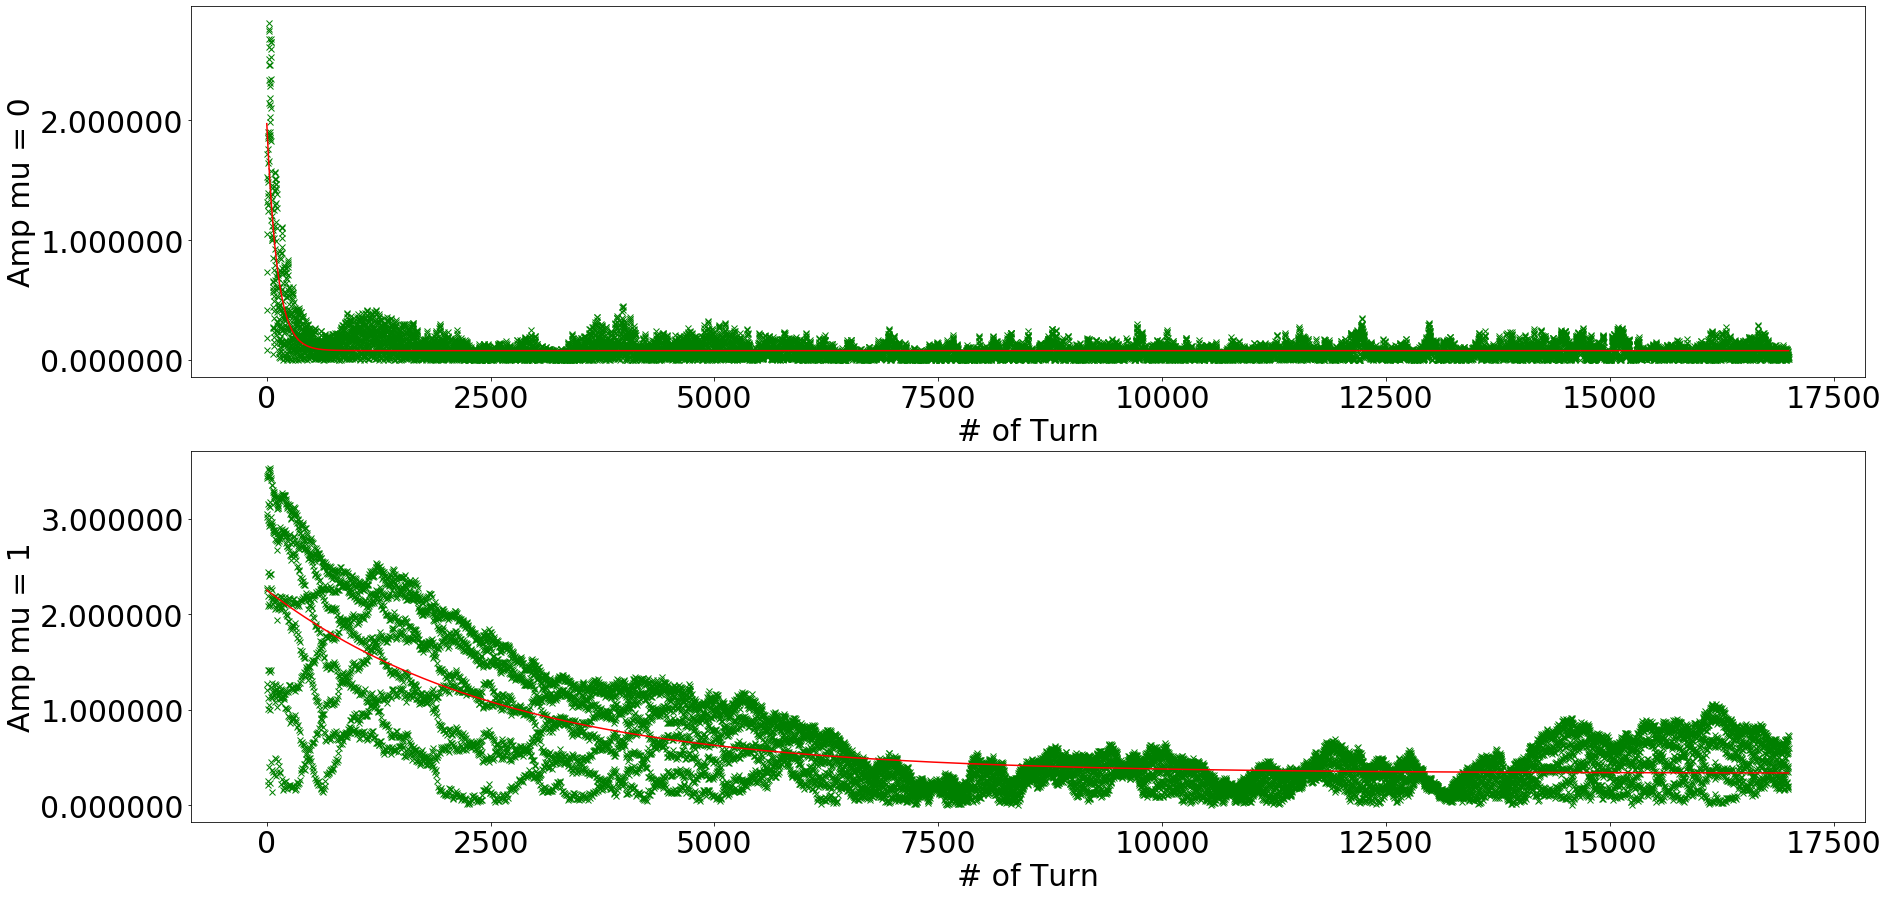

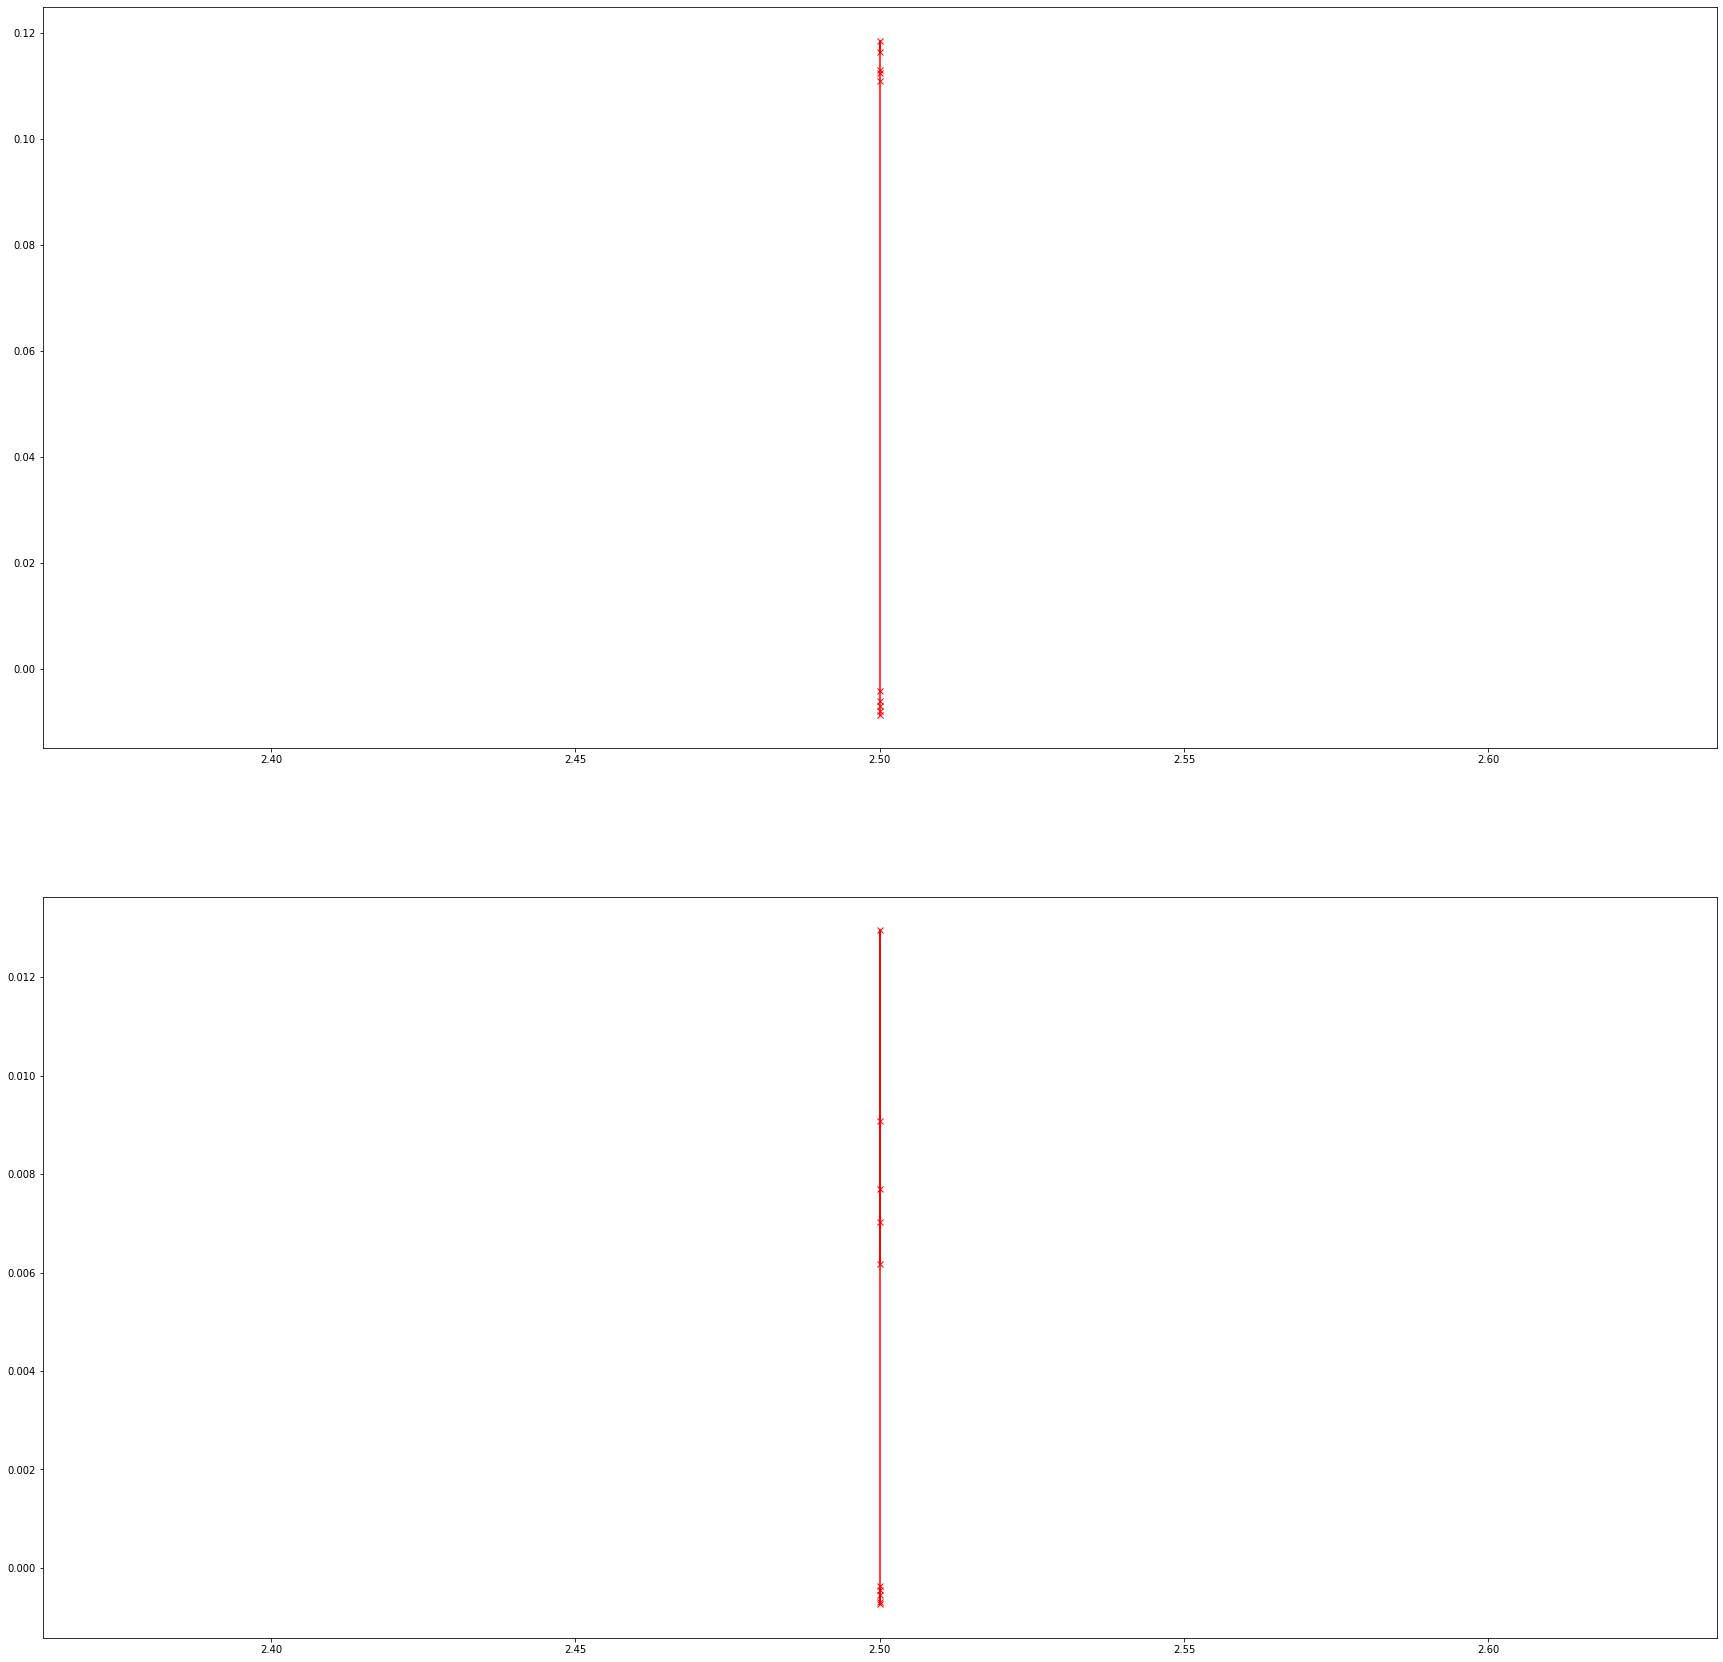

In [39]:
# get the fitted growth rate
# first, find the turn number where the mu=1 mode amplitude exceed certain value
def get_the_turn_number(c,value):
    for i in range(len(c)):
        if c[i]>=value:
            return i
    return i

inputfn = 'input.txt'
datafn = 'data.bin'

N_mode = 2 # number of mode to look
mu_danger = 0 # the mode we think is the most dangers
mus = range(N_mode)
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
qs = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
taus = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
qs = np.ndarray([N_mode,len(new_folders)])
taus = np.ndarray([N_mode,len(new_folders)])

q_guess = 0.01
qidx = 0
folders.sort()
for folder in new_folders[:]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    if nRF ==1:
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
    elif nRF == 2 :
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])

# calculate the components
    sincomp = []
    coscomp = []
    a = np.ndarray([N_mode,nTurns])
    b = np.ndarray([N_mode,nTurns])
    c = np.ndarray([N_mode,nTurns])
    
    value = 100 # the value where we stop the plotting
    idx = np.zeros(N_mode)
    
    fig1,axes1 = plt.subplots(N_mode,1)
    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    
    for mu in range(N_mode):
        sincomp.append(np.sin(-mu*2*pi*f0*np.array(centroids)))
        coscomp.append(np.cos(-mu*2*pi*f0*np.array(centroids)))
        for i in range(nTurns):
            a[mu][i] = np.sum(sincomp[mu]*M1_2[i*nBunch:(i+1)*nBunch])/len(sincomp[mu])
            b[mu][i] = np.sum(coscomp[mu]*M1_2[i*nBunch:(i+1)*nBunch])/len(coscomp[mu])
        c[mu] = np.sqrt(np.array(a[mu])**2+np.array(b[mu])**2)
        
        idx[mu] = get_the_turn_number(c[mu],value)
        print("The turn number when amplitude reach ",value,":",idx[mu])
        
        # fit the growth rate
        rng1 = nDynamic
        rng2 = int(idx[mu])
        if rng1>rng2:
            rng1 = 0
        cNew = c[mu][rng1:rng2]
        turn_temp = range(rng2-rng1)
        # the guessed value of growth rate
        if qidx<=25:
            q_guess = 0.3
        else:
            q_guess = 0.3
        popt, pcov = curve_fit(func_exp_fit, turn_temp, \
                               cNew,bounds=([-cNew[0]*100,-q_guess,-cNew[0]*100], [cNew[0]*100, q_guess, cNew[0]*100]),\
                               maxfev=20000000)
        print(popt)
        print(pcov)
        qs[mu][qidx] = popt[1]
        c_fit =  popt[0]*np.exp(popt[1]*turn_temp)+popt[2]
        axes1[mu].plot(c[mu][rng1:rng2],'gx')
        axes1[mu].plot(c_fit,'r-')
        axes1[mu].tick_params(labelsize=50)

        axes1[mu].set_xlabel('# of Turn',fontsize=30)
        axes1[mu].set_ylabel('Amp mu = '+str(mu),fontsize=30)

        axes1[mu].tick_params(labelsize=30)
        y_labels = axes1[mu].get_yticks()
        axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))
    qidx+=1 # for each parameter sample point
    fn_after = os.path.join(cwd,'CB_Modes.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(current,qs[mu],'rx-')
plt.show()
os.chdir(home0)

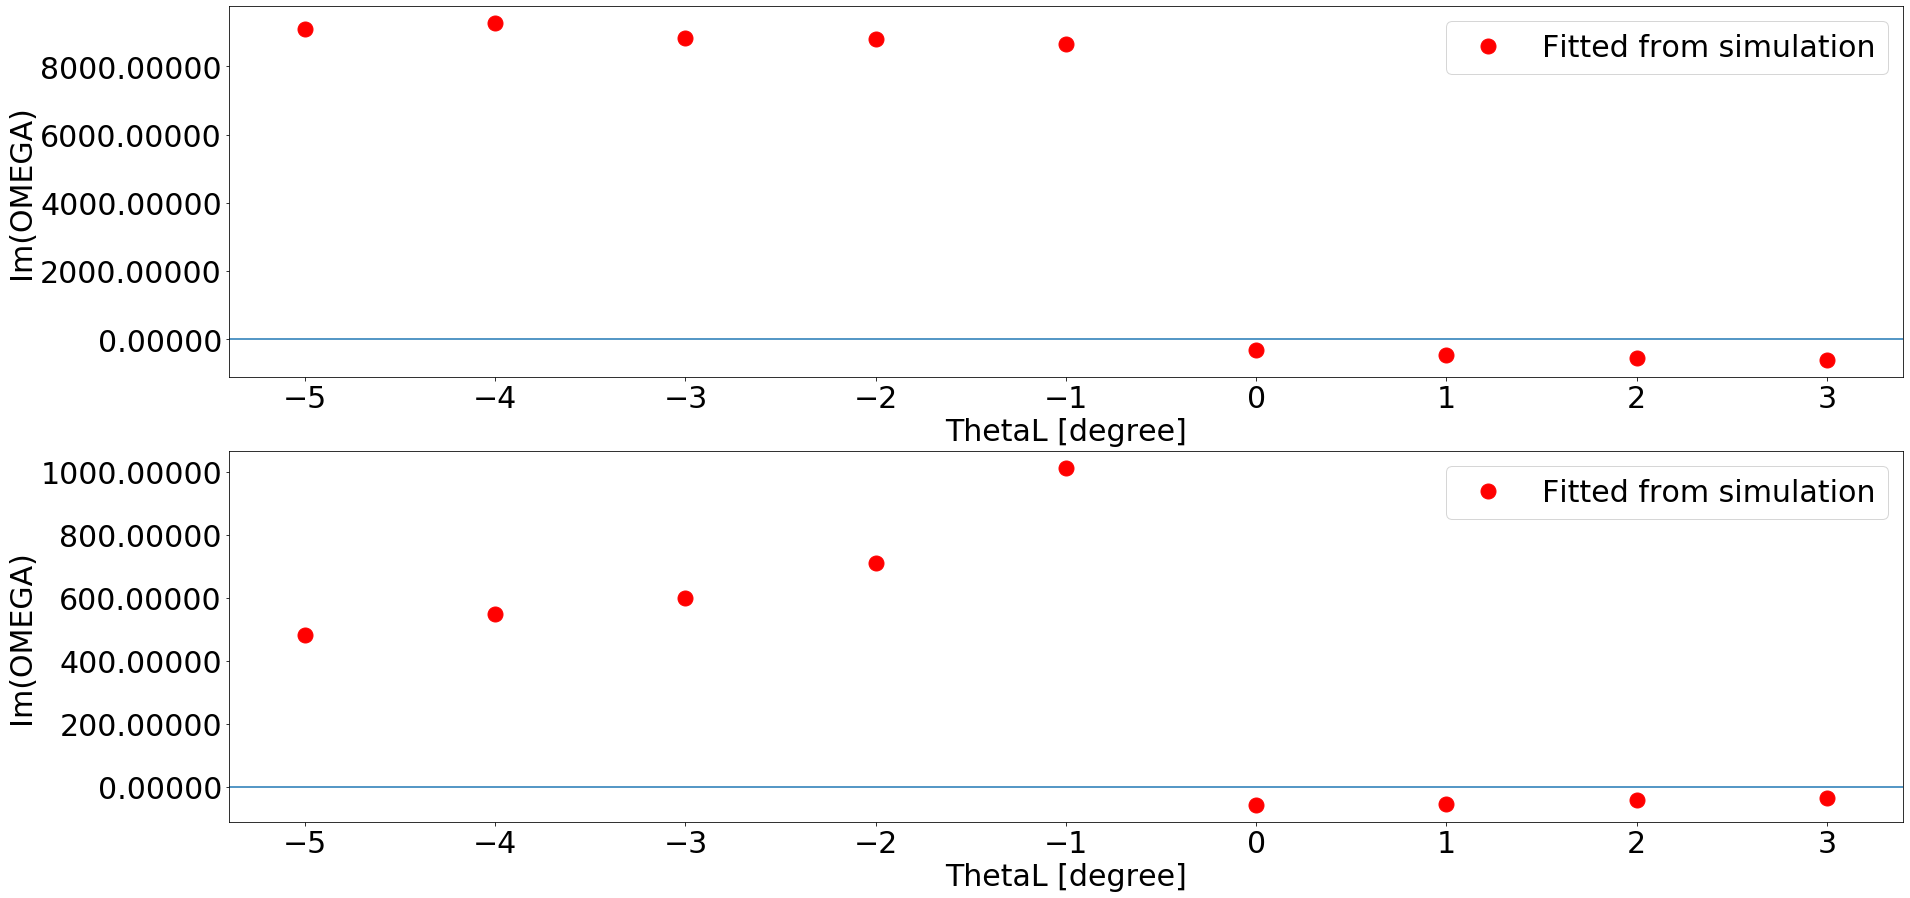

In [40]:
# Omega_Im = qs/T0 vs thetaL
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)-1
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(thetaL[rng1:rng2],qs[mu][rng1:rng2]/T0,'r.', ms=30)
    axes1[mu].axhline(y=0)
    axes1[mu].set_ylabel('Im(OMEGA)',fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    axes1[mu].legend(["Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

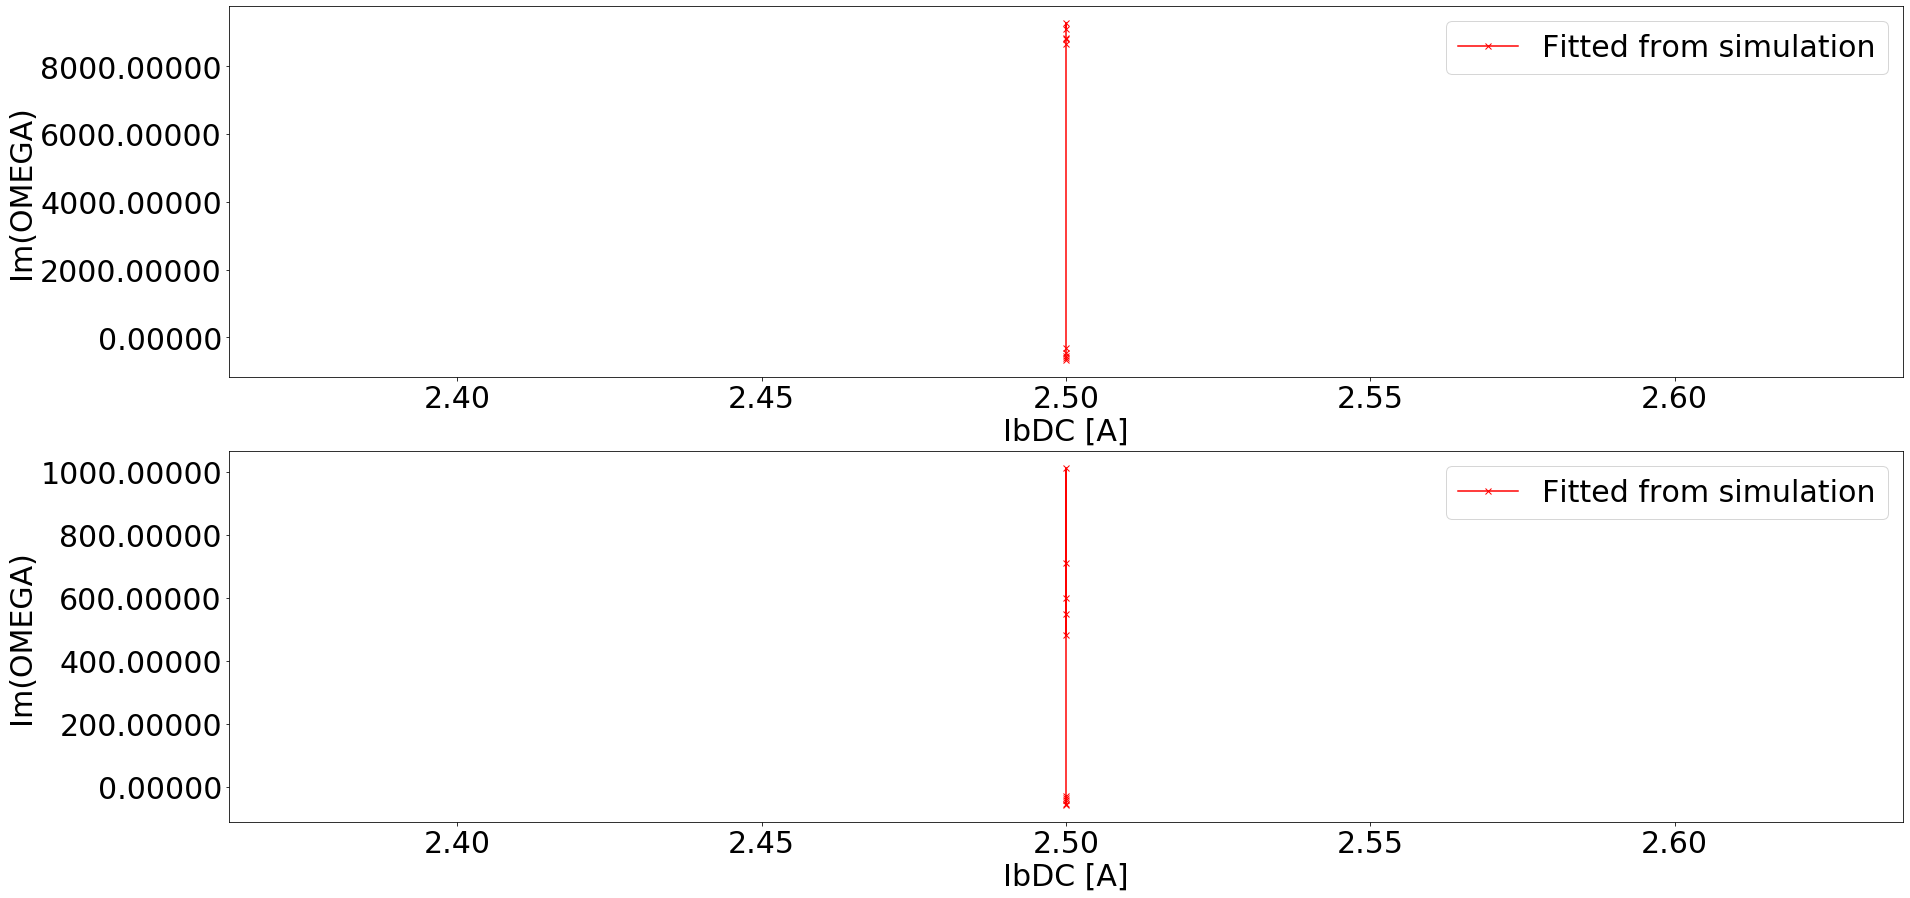

In [41]:
# Omega_Im = qs/T0 vs current
os.chdir(home1)
cwd = os.getcwd()
rng1 = 0
rng2 = len(thetaL)-1
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(current,qs[mu]/T0,'rx-')
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].set_ylabel('Im(OMEGA)',fontsize=30)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend(["Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [42]:
# get analitical number from simple formula (Chao's book)
def Zparallel(Rsh, QL, omega0, omega):
    return Rsh*omega/(omega+1j*QL*(omega0-omega**2/omega0)) # using the convention from A. Chao's book
# Small tune shift approximation
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = 1*nBunch # number of samples in frequency domain

#only look at the mu=? mode
mu = 0
delta_omega_Re = np.zeros(len(new_folders))
delta_omega_Im = np.zeros(len(new_folders))

delta_omega_Re = np.ndarray([N_mode,len(new_folders)])
delta_omega_Im = np.ndarray([N_mode,len(new_folders)])
ps = np.array([float(i) for i in range(-pmax,pmax)])

p_M_omega0 = ps*nBunch*2*np.pi*f0

omegas = Qs*2*pi*f0
for mu in mus:
    qidx=0
    for folder in new_folders[:]:
        #print(folder)
        os.chdir(os.path.join(home1,folder))
        cwd = os.getcwd()
        inputfile = os.path.join(cwd,inputfn)
        tempinput = {}
        with open(inputfile) as inputfile:
            for line in inputfile:
                if len(line.split())>1:
                    tempinput[line.split()[0]] = line.split()[1:]
        for i in tempinput:
            for j in range(len(tempinput[i])):
                tempinput[i][j] = float(tempinput[i][j])
        nRF = int(tempinput['nRF'][0])
        nRF1 = int(tempinput['nRF1'][0])
        nRF2 = int(tempinput['nRF2'][0])
        nRFc = int(tempinput['nRFc'][0])


        nTurns = int(tempinput['n_turns'][0])
        nfill = int(tempinput['n_fill'][0])
        n_q_ramp = int(tempinput['n_q_ramp'][0])
        NpRF = int(tempinput['N_bins'][0])
        h = [int(i) for i in tempinput['h']]
        detune_ini = np.array([i for i in tempinput['detune_ini']])
        detune_final = np.array([i for i in tempinput['detune_final']])

        step = int(tempinput['step_store'][0])
        fill_step = int(tempinput['fill_step'][0])
        nBeam = int(tempinput['nBeam'][0])
        beam_shift = int(tempinput['beam_shift'][0])
        nBunch = int(tempinput['n_bunches'][0])
        nPar = int(tempinput['Npar'][0])
        NperBunch = int(tempinput['NperBunch'][0])
        nTot = nBunch*nPar*nBeam
        Gamma0 = tempinput['Gamma'][0]
        Rring = tempinput['R'][0]
        n_record = nTurns/step
        beta = np.sqrt(1-1/Gamma0**2)
        T0 = 2*np.pi*Rring/(clight*beta)
        f0 = 1/T0
        V0 = [i for i in tempinput['Vref_I']]
        V0Q = [i for i in tempinput['Vref_Q']]
        II = [i for i in tempinput['Iref_I']]
        IQ = [i for i in tempinput['Iref_Q']]
        mainRF = int(tempinput['mainRF'][0])
        Pbeam = tempinput['Prad'][0]
        if int(tempinput['type'][0]==2):
            atomicZ = 79
            Ek = Gamma0*E0Au
        else:
            atomicZ =1
        if int(tempinput['type'][0]==1):  
            Ek = Gamma0*E0Elec

        GMTSQ = tempinput['GMTSQ'][0]
        Ek_damp = tempinput['Ek_damp'][0]

        eta = 1/GMTSQ-1/Gamma0**2
        if nRF ==1:
            Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
        elif nRF == 2 :
            Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))
        print("Qs: ",Qs)
        omegarf = 2*np.pi*(np.array(h)*f0)
        omegac = 2*np.pi*(np.array(h)*f0+detune_final)
        Trf = 2*np.pi/omegarf
        RoQ = [i for i in tempinput['RoQ']]
        QL = [i for i in tempinput['QL']]
        R = [RoQ[i]*QL[i] for i in range(nRF)]

        Th = 2*np.pi/omegarf[0]
        dthat =Th/NpRF

        pattern = 'd'+'dd'*nBeam+3*nRF*'d'
        n_stride = 1+2*nBeam+3*nRF
        stride = len(pattern)*8

        # for the calculation of real part of Omega

        omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas) # using incoherent omegas for approximation
        Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
        factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas) # using incoherent omegas for approximation
        deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))
        # for the calculation of the imaginary part of Omega
        omegas2 = ((ps*nBunch+(-mu))*2*np.pi*f0+(omegas))

        factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

        Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
        deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
        delta_omega_Re[mu][qidx] = deltaOmegaRe
        delta_omega_Im[mu][qidx] = deltaOmegaIm
        print(deltaOmegaRe/2/pi,deltaOmegaIm)
        qidx+=1


Qs:  0.05410554940716556
-91.63252587403711 -8.960243103719763e-07
Qs:  0.05410554940716556
-91.63250225781574 -8.960135958161372e-07
Qs:  0.05410554940716556
-91.63247869923907 -8.960029075416587e-07
Qs:  0.05410554940716556
-91.6324551837888 -8.959922389574457e-07
Qs:  0.05410554940716556
-91.63243169705228 -8.959815835210887e-07
Qs:  0.05410554940716556
-91.63240822468687 -8.959709347268742e-07
Qs:  0.05410554940716556
-91.63238475238508 -8.959602860932499e-07
Qs:  0.05410554940716556
-91.63236126583956 -8.959496311101419e-07
Qs:  0.05410554940716556
-91.63233775070819 -8.959389632900034e-07
Qs:  0.05410554940716556
-91.6323141925791 -8.959282760882446e-07
Qs:  0.05410554940716556
-91.63259396091942 1.4640014653100534e-05
Qs:  0.05410554940716556
-91.63257034381253 1.4639827593816626e-05
Qs:  0.05410554940716556
-91.63254678435257 1.4639640993299609e-05
Qs:  0.05410554940716556
-91.63252326802062 1.4639454736548116e-05
Qs:  0.05410554940716556
-91.63249978040345 1.4639268709395157e-

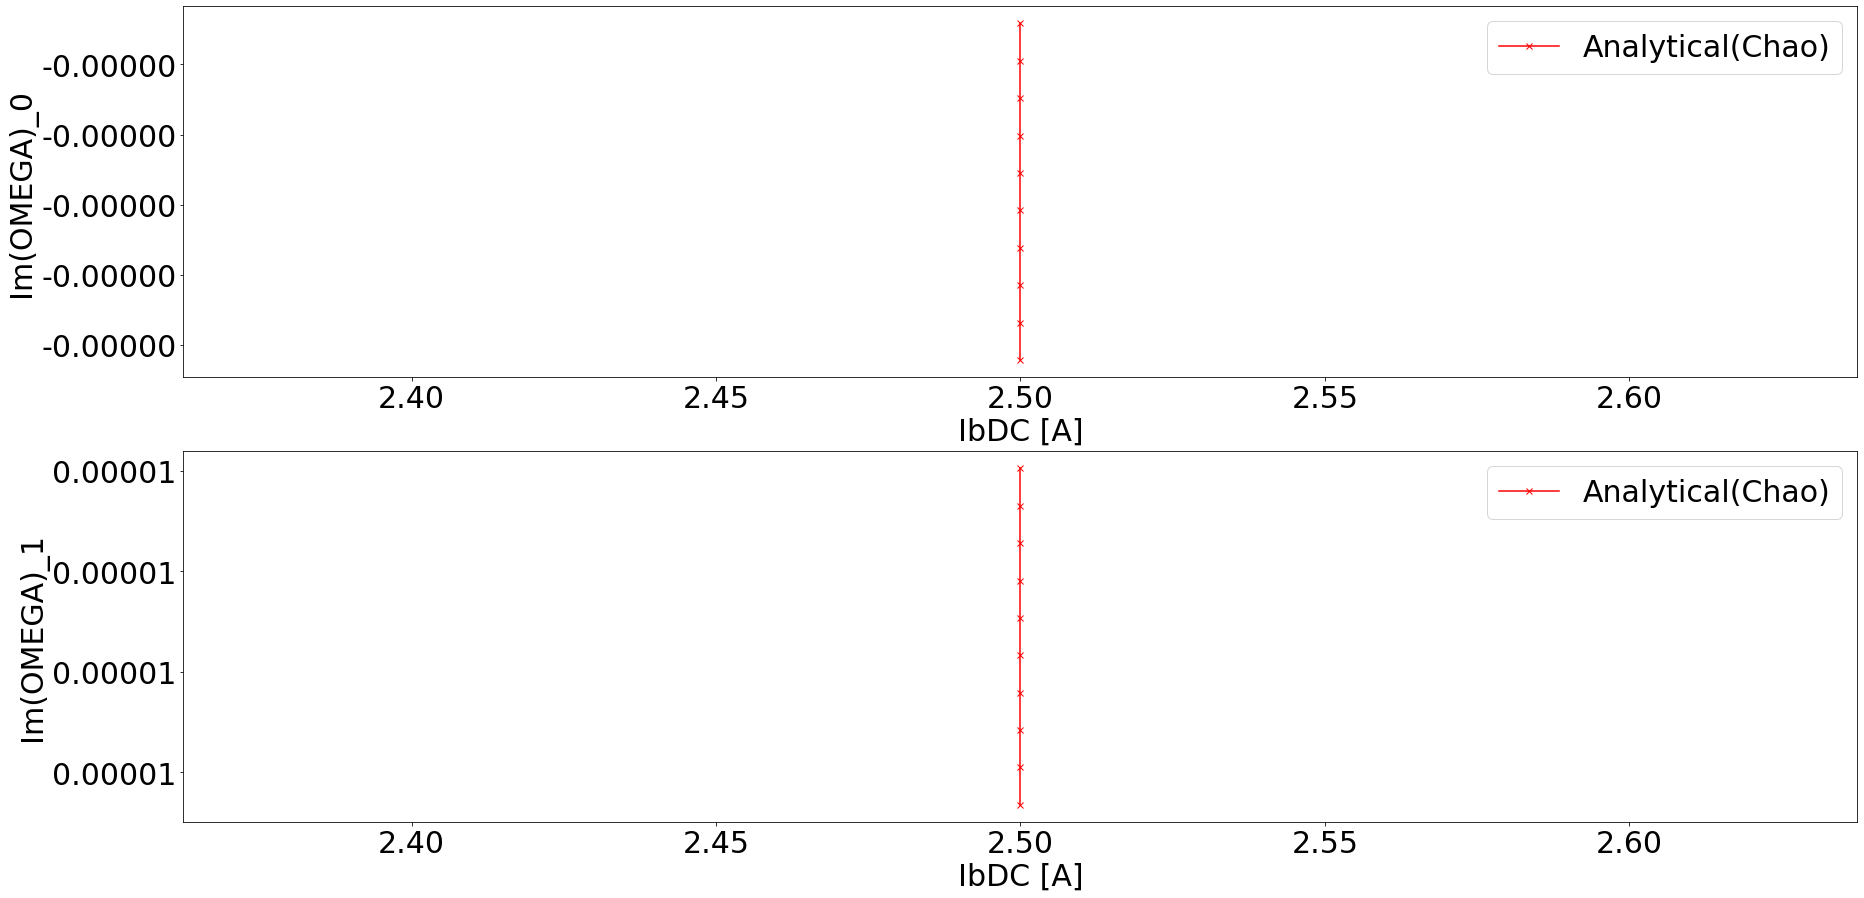

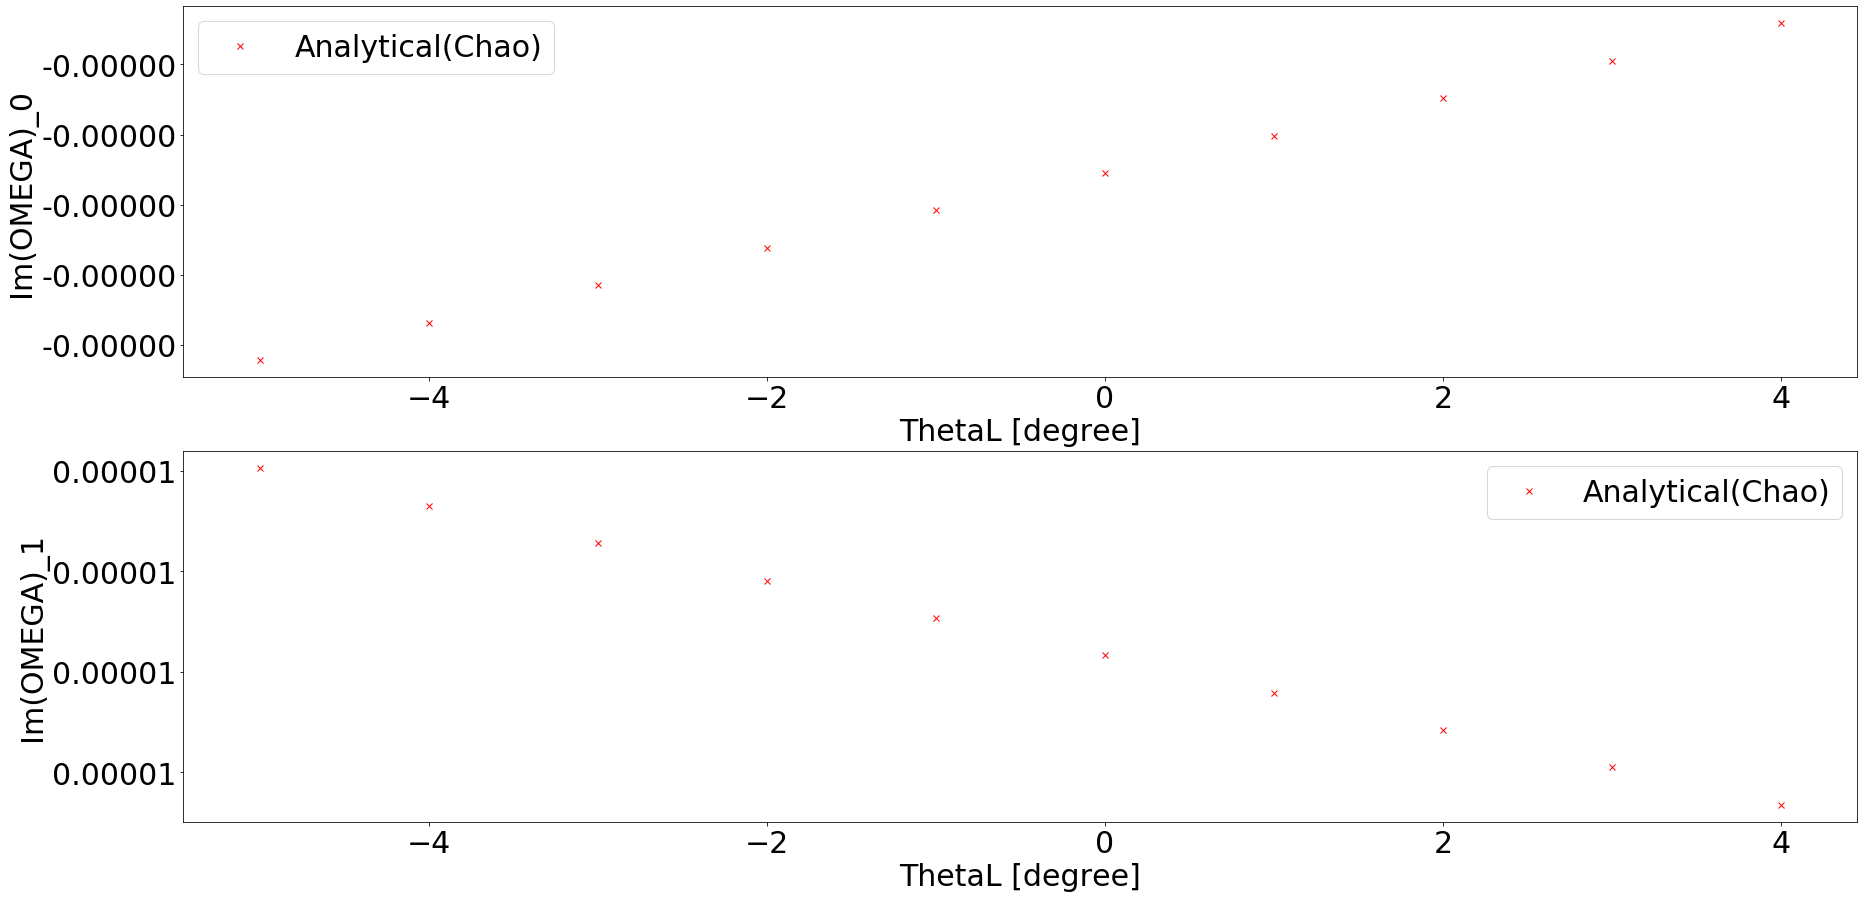

In [43]:
# growth rate Omega_Im vs current and vs thetaL
os.chdir(home1)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(current,delta_omega_Im[mu],'rx-')
    axes1[mu].set_ylabel('Im(OMEGA)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
fn_growth_rate = os.path.join(cwd,'growth_rate_analytical.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(thetaL,delta_omega_Im[mu],'rx')
    axes1[mu].set_ylabel('Im(OMEGA)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_analytical_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [44]:
# iterative solver
def F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0):
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R[i],QL[i],omegac[i],omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    return Omega**2-(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)

def SolveOmega(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    # initial values
    OmegaR = np.real(Omega)
    OmegaI = np.imag(Omega)
    # step size
    sig1 = 1
    sig2 = 1*1j
    Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
    
    while(np.abs(Err)>accu and nIter<maxIter):
        OmegaR = np.real(Omega)
        OmegaI = np.imag(Omega)
        Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
        F1 = F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaRe by a small step
        F2 = F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaIm by a small step
        Fre = np.real(Err)
        Fim = np.imag(Err)
        F1re = np.real(F1)
        F1im = np.imag(F1)
        F2re = np.real(F2)
        F2im = np.imag(F2)
        # approximate the Jacobian
        dF11 = F1re-Fre
        dF12 = F2re-Fre
        dF21 = F1im-Fim
        dF22 = F2im-Fim
        
        det = dF11*dF22-dF12*dF21
        # inverse the Jacobian
        dF11inv = dF22/det
        dF12inv = -dF12/det
        dF21inv = -dF21/det
        dF22inv = dF11/det

        OmegaR -= Fre*dF11inv+Fim*dF12inv
        OmegaI -= Fre*dF21inv+Fim*dF22inv
        Omega = OmegaR+OmegaI*1j
        nIter += 1
    
    return Omega
    print(Omega)
    print(np.abs(Err))
    print(nIter)

In [45]:
# Iteratively solve:
delta_omega_Re_Iter = np.zeros(len(new_folders))
delta_omega_Im_Iter = np.zeros(len(new_folders))
delta_omega_Re_Iter = np.ndarray([N_mode,len(new_folders)])
delta_omega_Im_Iter = np.ndarray([N_mode,len(new_folders)])
N_OMEGA_guss = 101
OMEAG_ini = [omegas*np.exp(1j*i/100*2*pi) for i in range(N_OMEGA_guss)]

for mu in mus:
    qidx=0

    for folder in new_folders[:]:
        #print(folder)
        os.chdir(os.path.join(home1,folder))
        cwd = os.getcwd()
        inputfile = os.path.join(cwd,inputfn)
        tempinput = {}
        with open(inputfile) as inputfile:
            for line in inputfile:
                if len(line.split())>1:
                    tempinput[line.split()[0]] = line.split()[1:]
        for i in tempinput:
            for j in range(len(tempinput[i])):
                tempinput[i][j] = float(tempinput[i][j])
        nRF = int(tempinput['nRF'][0])
        nRF1 = int(tempinput['nRF1'][0])
        nRF2 = int(tempinput['nRF2'][0])
        nRFc = int(tempinput['nRFc'][0])


        nTurns = int(tempinput['n_turns'][0])
        nfill = int(tempinput['n_fill'][0])
        n_q_ramp = int(tempinput['n_q_ramp'][0])
        NpRF = int(tempinput['N_bins'][0])
        h = [int(i) for i in tempinput['h']]
        detune_ini = np.array([i for i in tempinput['detune_ini']])
        detune_final = np.array([i for i in tempinput['detune_final']])

        step = int(tempinput['step_store'][0])
        fill_step = int(tempinput['fill_step'][0])
        nBeam = int(tempinput['nBeam'][0])
        beam_shift = int(tempinput['beam_shift'][0])
        nBunch = int(tempinput['n_bunches'][0])
        nPar = int(tempinput['Npar'][0])
        NperBunch = int(tempinput['NperBunch'][0])
        nTot = nBunch*nPar*nBeam
        Gamma0 = tempinput['Gamma'][0]
        Rring = tempinput['R'][0]
        n_record = nTurns/step
        beta = np.sqrt(1-1/Gamma0**2)
        T0 = 2*np.pi*Rring/(clight*beta)
        f0 = 1/T0
        V0 = [i for i in tempinput['Vref_I']]
        V0Q = [i for i in tempinput['Vref_Q']]
        II = [i for i in tempinput['Iref_I']]
        IQ = [i for i in tempinput['Iref_Q']]
        mainRF = int(tempinput['mainRF'][0])
        Pbeam = tempinput['Prad'][0]
        if int(tempinput['type'][0]==2):
            atomicZ = 79
            Ek = Gamma0*E0Au
        else:
            atomicZ =1
        if int(tempinput['type'][0]==1):  
            Ek = Gamma0*E0Elec

        GMTSQ = tempinput['GMTSQ'][0]
        Ek_damp = tempinput['Ek_damp'][0]

        eta = 1/GMTSQ-1/Gamma0**2
        if nRF ==1:
            Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
        elif nRF == 2 :
            Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))
        print("Qs: ",Qs)
        omegarf = 2*np.pi*(np.array(h)*f0)
        omegac = 2*np.pi*(np.array(h)*f0+detune_final)
        Trf = 2*np.pi/omegarf
        RoQ = [i for i in tempinput['RoQ']]
        QL = [i for i in tempinput['QL']]
        R = [RoQ[i]*QL[i] for i in range(nRF)]

        Th = 2*np.pi/omegarf[0]
        dthat =Th/NpRF

        pattern = 'd'+'dd'*nBeam+3*nRF*'d'
        n_stride = 1+2*nBeam+3*nRF
        stride = len(pattern)*8
        test = array('d')
        print("dfc: ",omegac/2/pi-f0*h[0])
        print("NperBunch: ",NperBunch/1e11)
        print("nBunch: ",nBunch)

        #print("QL: ",QL)
        #print("R: ",R)
        maxOMEGAIM = -1e360
        for Omega in OMEAG_ini:
            temp = SolveOmega(Omega,ps,-mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,200,1e-9)
            if np.imag(temp)>maxOMEGAIM:
                maxOMEGAIM = np.imag(temp)
                delta_omega_Re_Iter[mu][qidx] = np.real(temp)
                delta_omega_Im_Iter[mu][qidx] = np.imag(temp)
        print(qidx,';',delta_omega_Re_Iter[mu][qidx]-omegas,delta_omega_Im_Iter[mu][qidx])
        qidx+=1


Qs:  0.05410554940716556
dfc:  [-14113.10421294]
NperBunch:  3.44513220978
nBunch:  580
0 ; -52584.35088982118 -7.838149001714214e-07
Qs:  0.05410554940716556
dfc:  [-14165.53364271]
NperBunch:  3.44513220978
nBunch:  580
1 ; -52584.351041528345 -7.838042158153449e-07
Qs:  0.05410554940716556
dfc:  [-14217.83523327]
NperBunch:  3.44513220978
nBunch:  580
2 ; -52584.35119286521 -7.837935576761372e-07
Qs:  0.05410554940716556
dfc:  [-14270.04121542]
NperBunch:  3.44513220978
nBunch:  580
3 ; -52584.35134392504 -7.837829191503257e-07
Qs:  0.05410554940716556
dfc:  [-14322.18358558]
NperBunch:  3.44513220978
nBunch:  580
4 ; -52584.3514948004 -7.837722937620555e-07
Qs:  0.05410554940716556
dfc:  [-14374.29418522]
NperBunch:  3.44513220978
nBunch:  580
5 ; -52584.35164558346 -7.837616749840378e-07
Qs:  0.05410554940716556
dfc:  [-14426.40477788]
NperBunch:  3.44513220978
nBunch:  580
6 ; -52584.3517963661 -7.8375105635864e-07
Qs:  0.05410554940716556
dfc:  [-14478.54712743]
NperBunch:  3.44

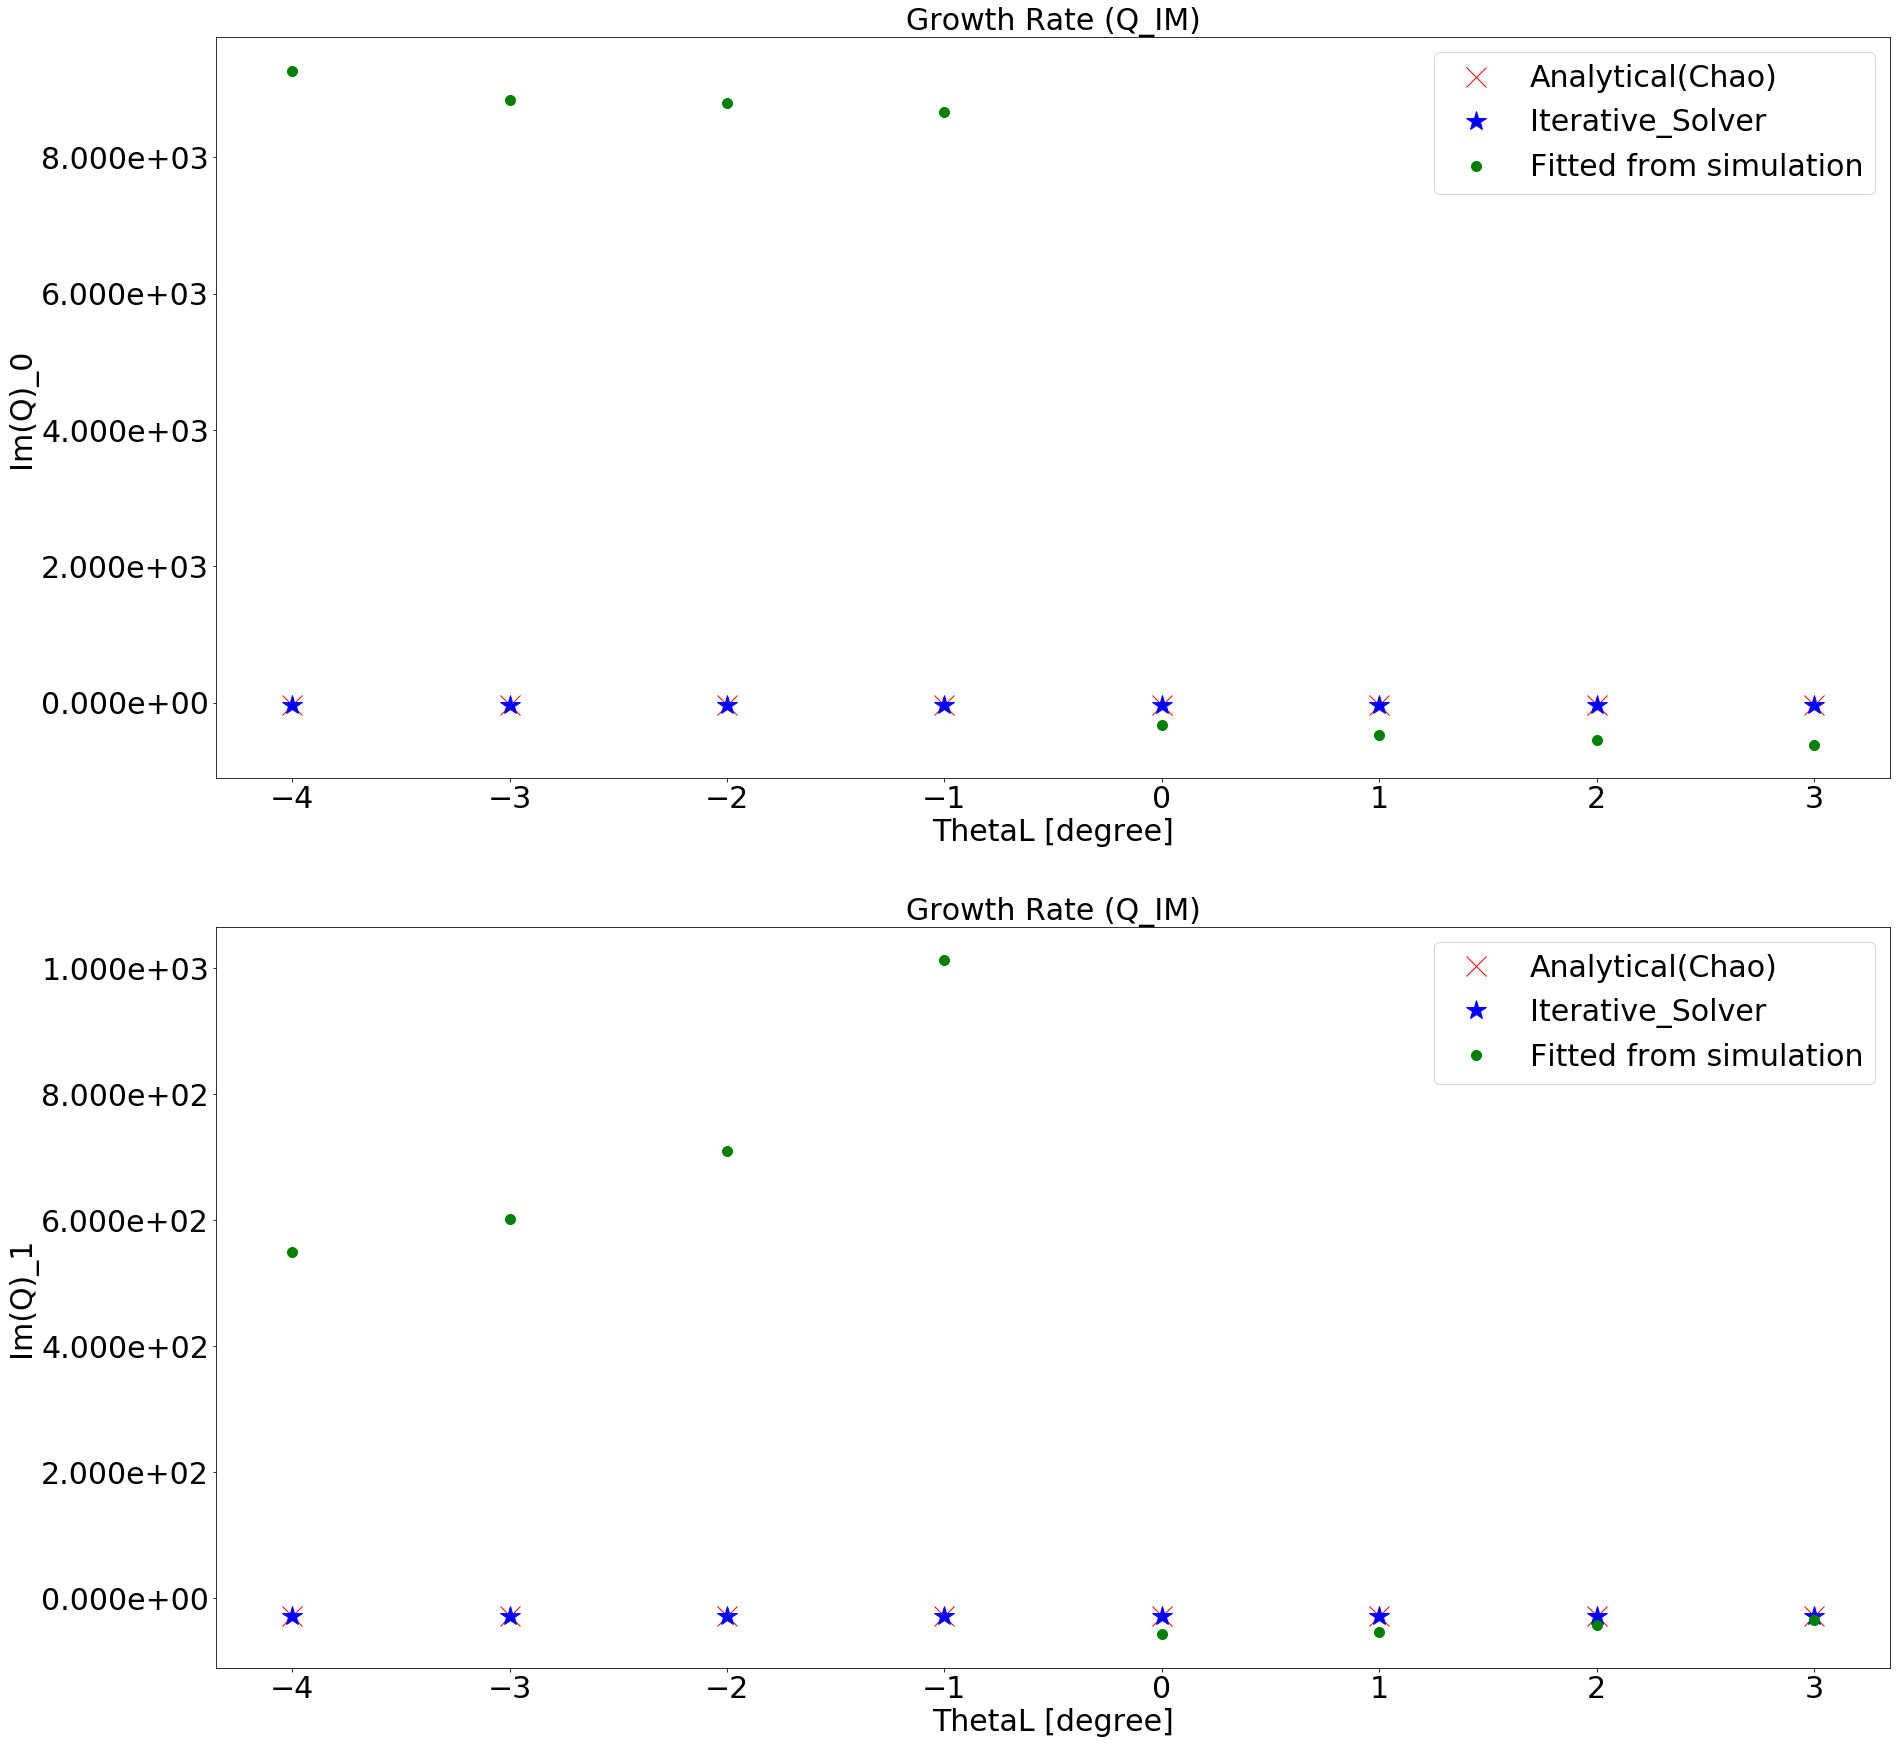

In [46]:
# plot the growth rate vs thetaL
os.chdir(home1)
cwd = os.getcwd()
rng1 = 1
rng2 = len(thetaL)-1
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(thetaL[rng1:rng2],delta_omega_Im[mu][rng1:rng2]-1/t_rad_long,'rx', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long,'b*', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],qs[mu][rng1:rng2]/T0,'g.', ms = 20)

    axes1[mu].set_title('Growth Rate (Q_IM)',fontsize=30)
    axes1[mu].set_ylabel('Im(Q)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3e'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

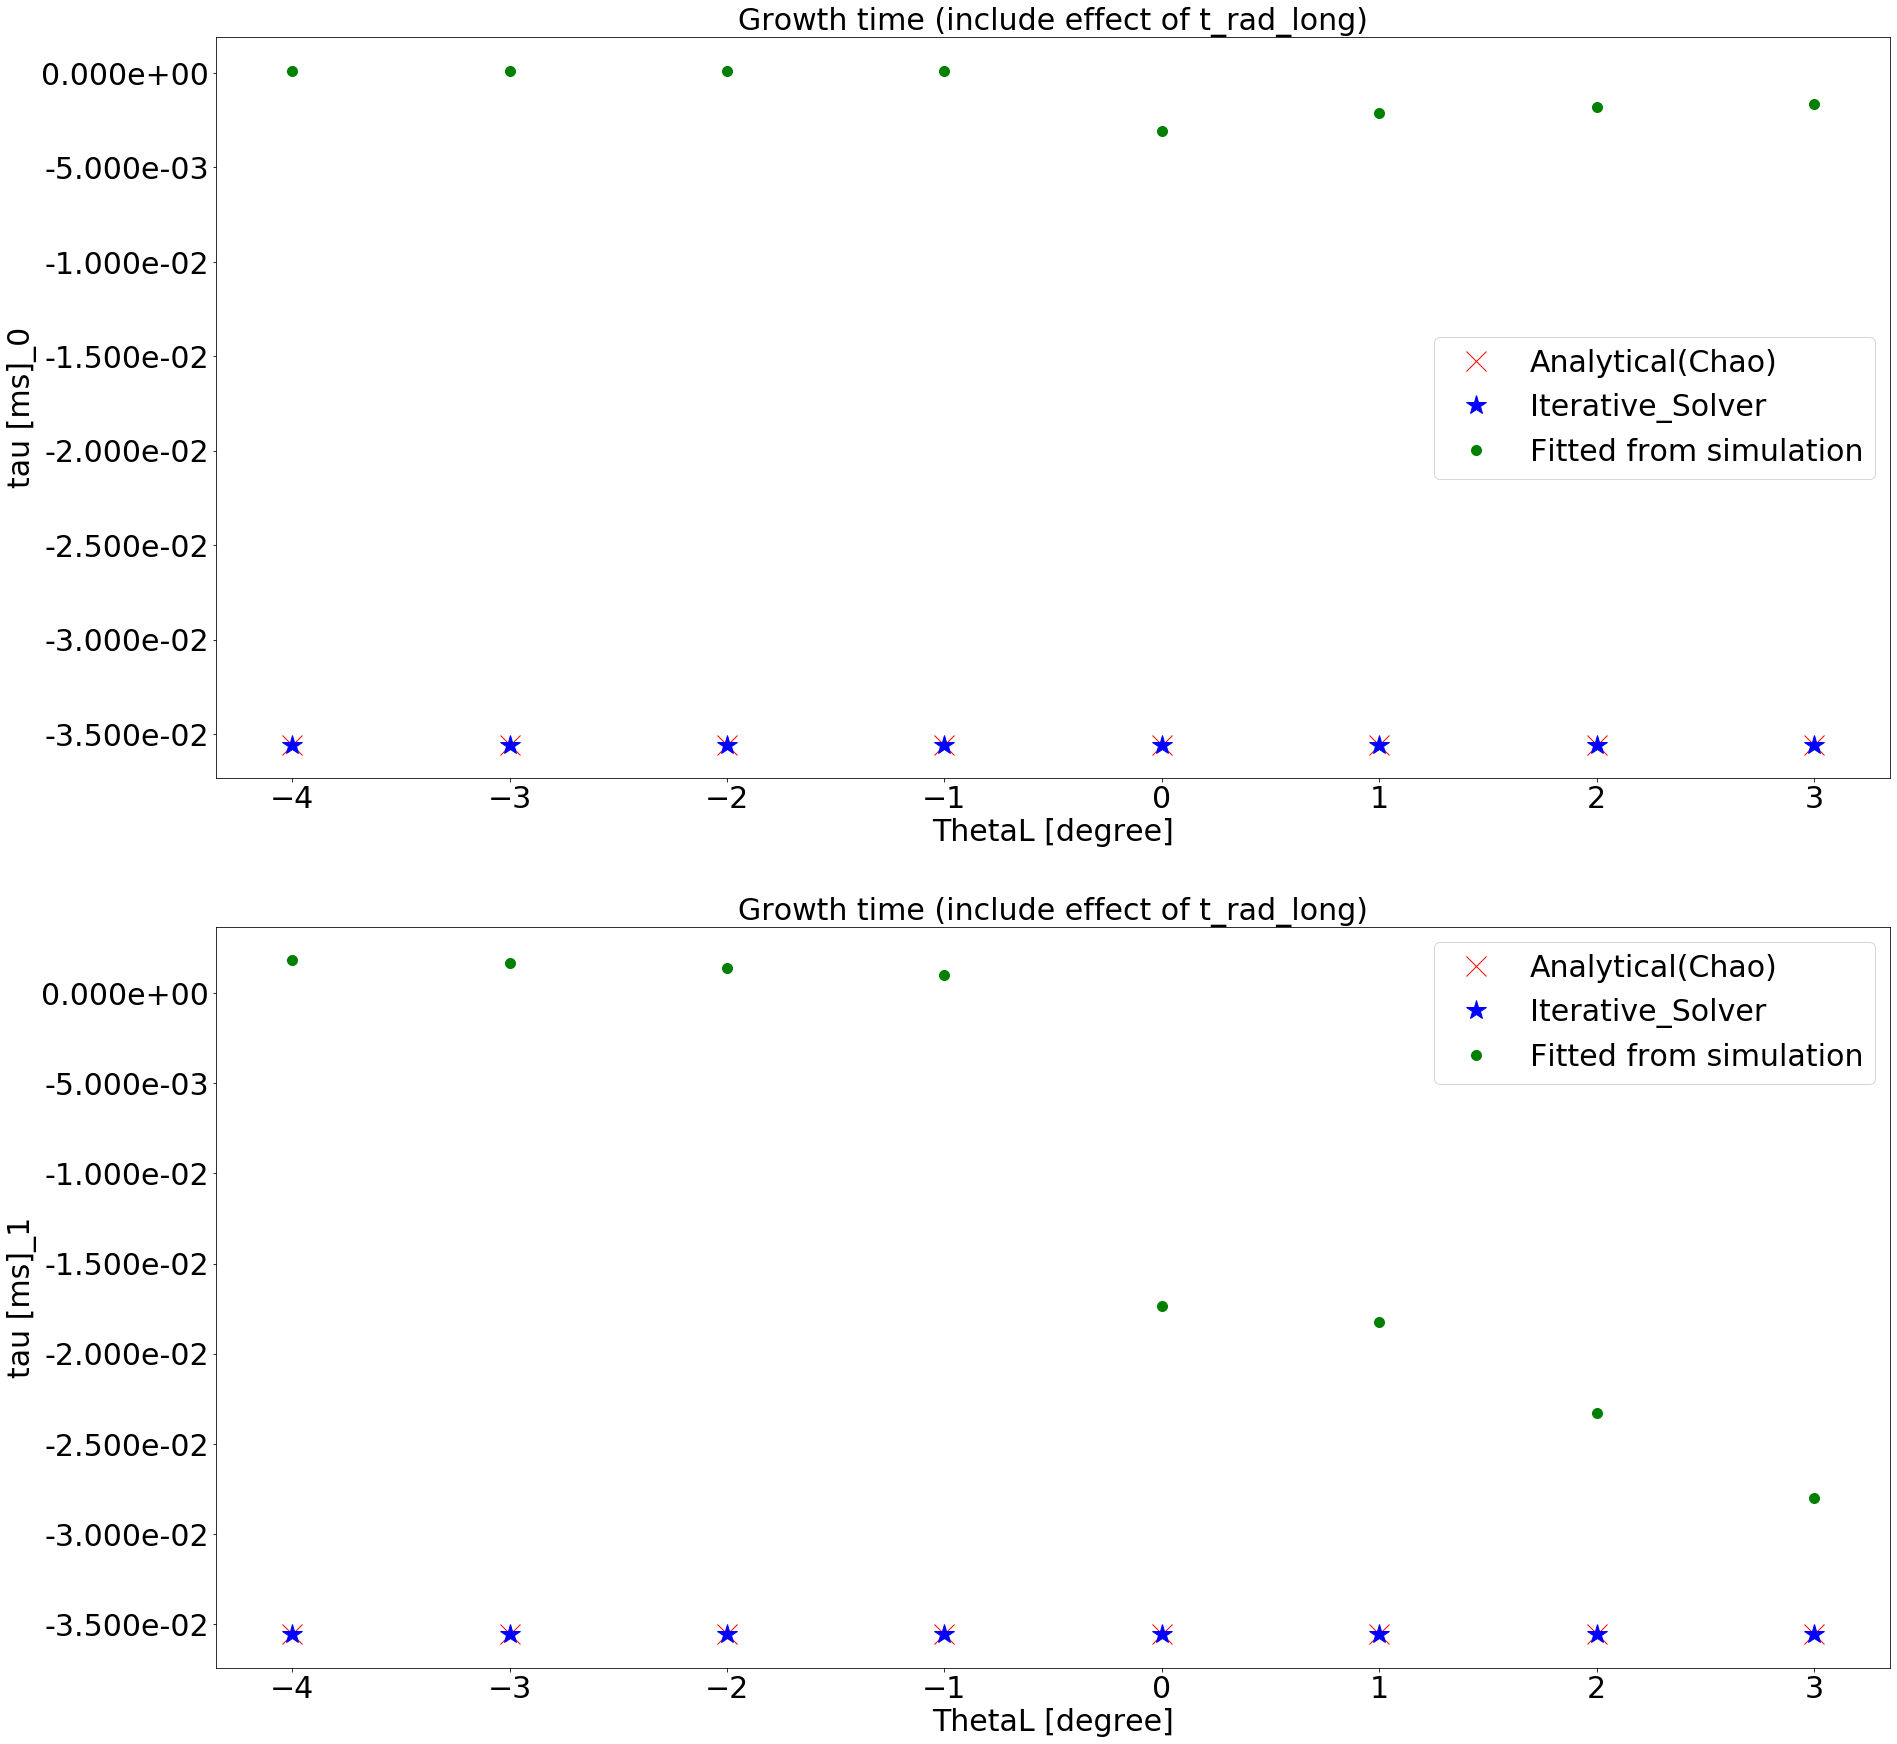

In [47]:
# plot the growth Time vs thetaL
os.chdir(home1)
cwd = os.getcwd()
rng1 = 1
rng2 = len(thetaL)-1
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
for mu in mus:
    axes1[mu].plot(thetaL[rng1:rng2],1/(delta_omega_Im[mu][rng1:rng2]-1/t_rad_long),'rx', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],1/(delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long),'b*', ms = 20)
    axes1[mu].plot(thetaL[rng1:rng2],1/(qs[mu][rng1:rng2]/T0),'g.', ms = 20)
    #axes1[0].set_ylim([-4e-4,4e-4])
    axes1[mu].set_title('Growth time (include effect of t_rad_long)',fontsize=30)
    axes1[mu].set_ylabel('tau [ms]_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('ThetaL [degree]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3e'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

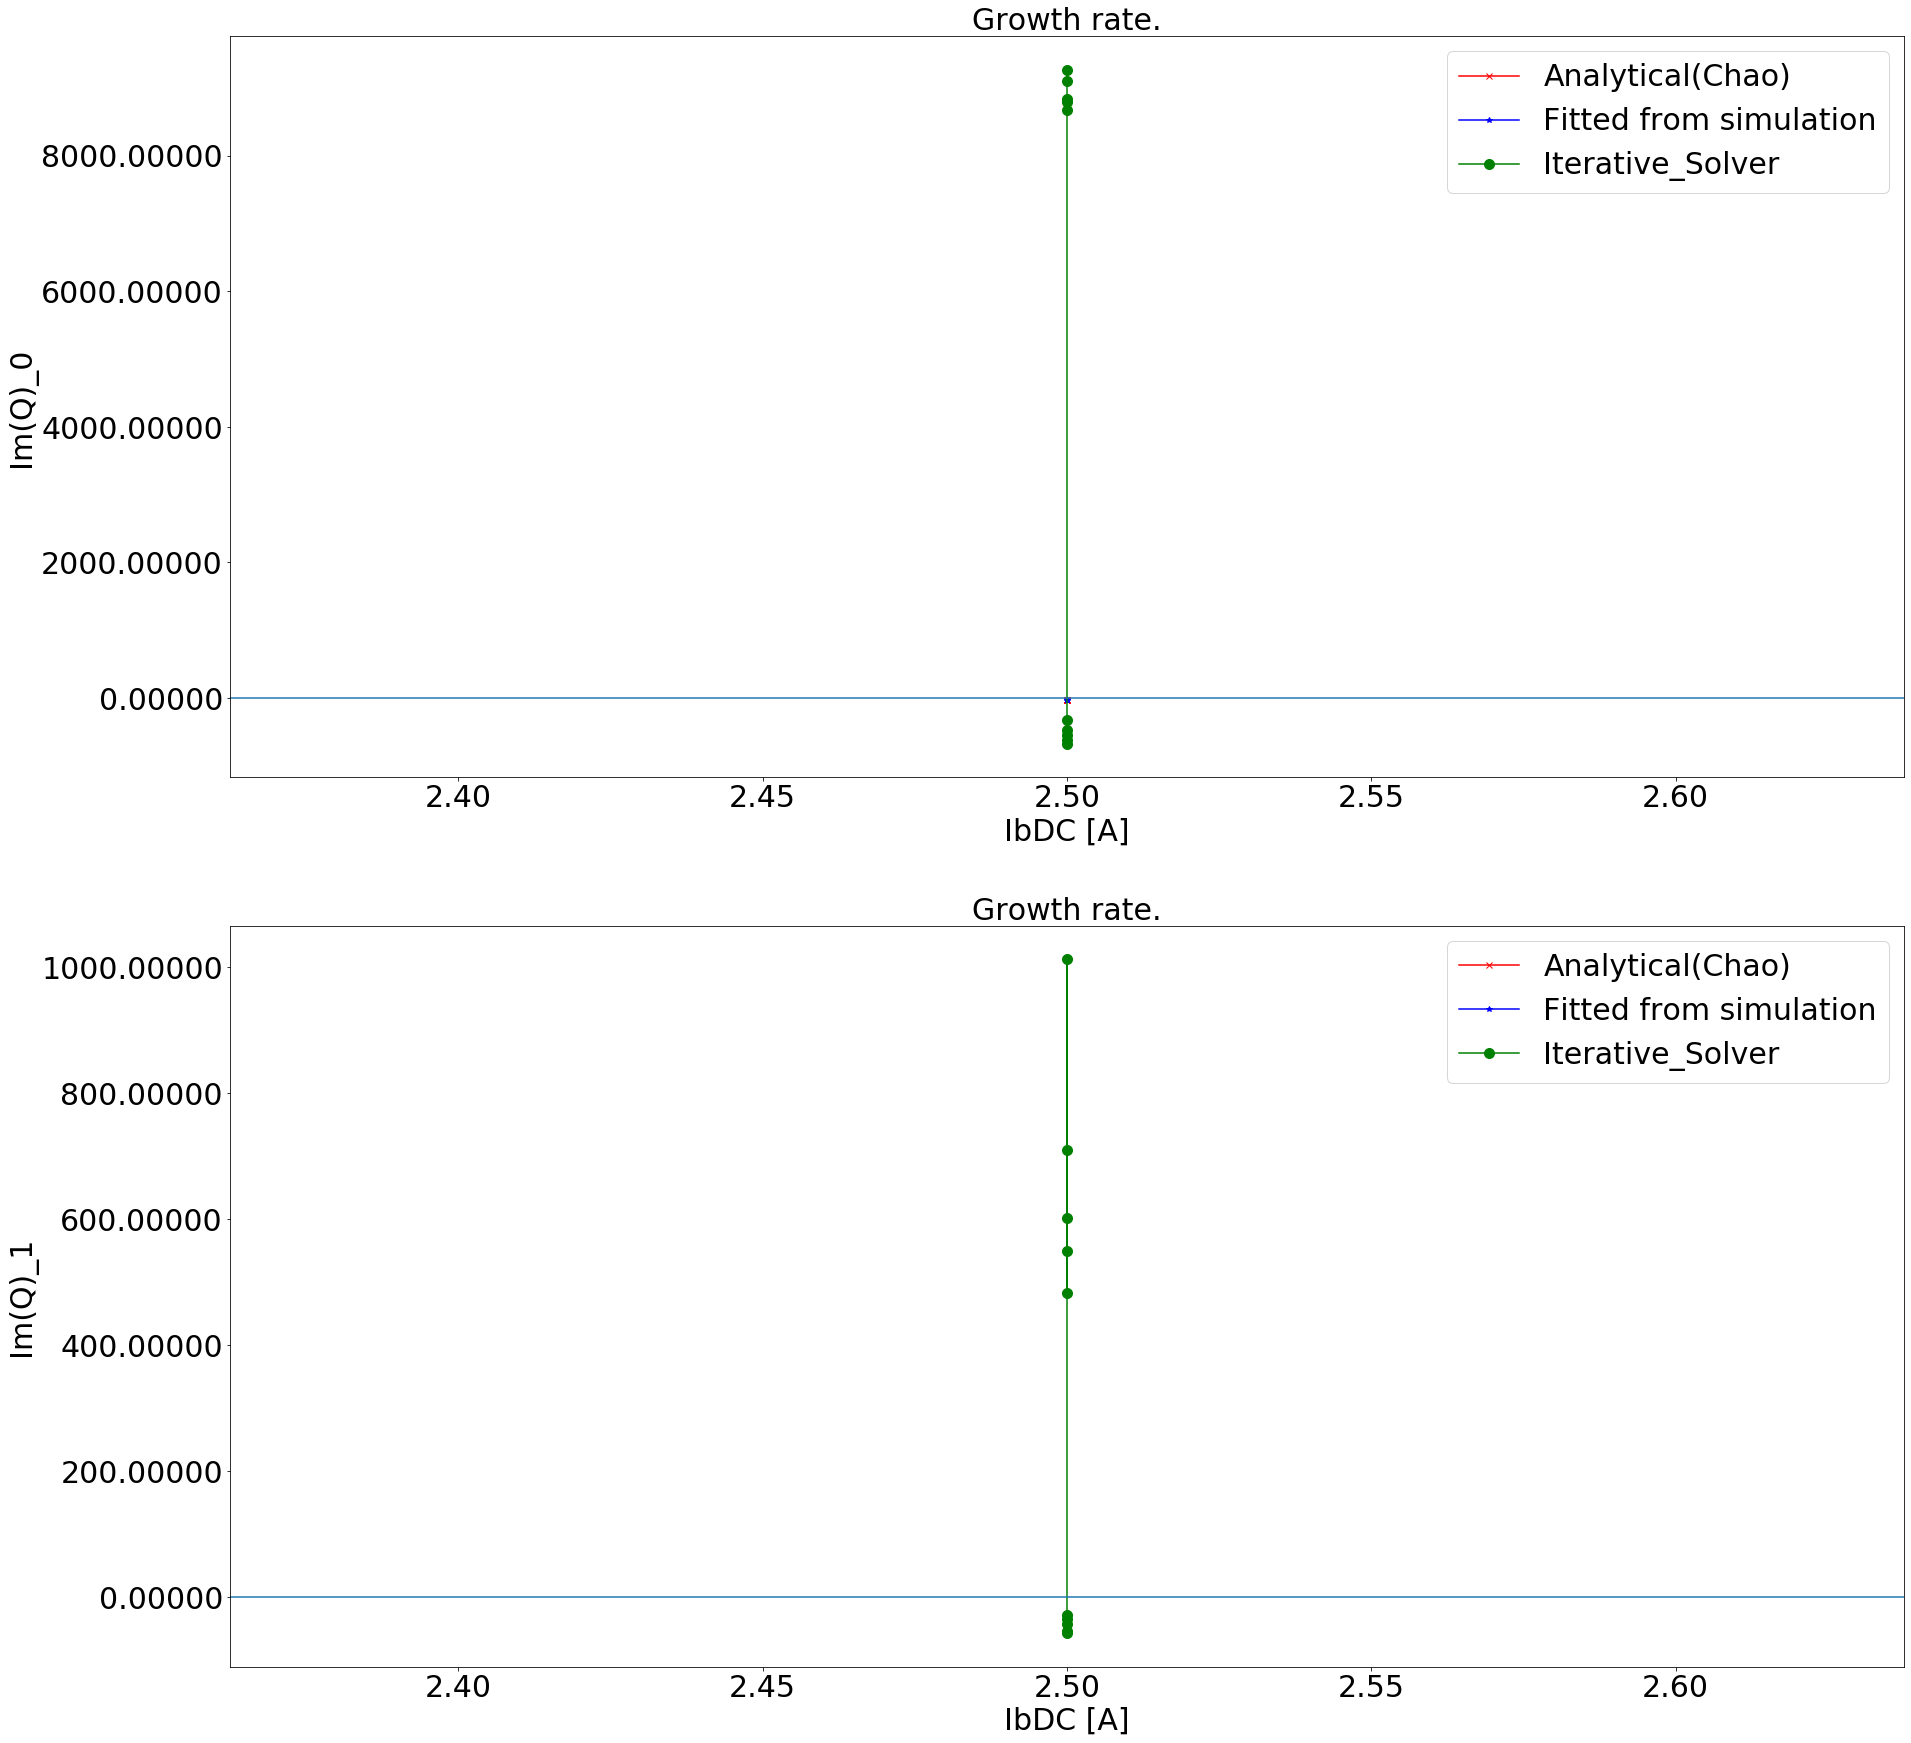

In [48]:
# plot the growth rate vs Ib
os.chdir(home1)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
for mu in mus:
    axes1[mu].plot(current[rng1:rng2],delta_omega_Im[mu][rng1:rng2]-1/t_rad_long,'rx-')
    axes1[mu].plot(current[rng1:rng2],delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long,'b*-')
    axes1[mu].plot(current[rng1:rng2],qs[mu][rng1:rng2]/T0,'g.-', ms = 20)
    #axes1[1].set_ylim([-2,2])
    axes1[mu].axhline(y=0)

    axes1[mu].set_title('Growth rate.',fontsize=30)
    axes1[mu].set_ylabel('Im(Q)_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation", "Iterative_Solver"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    #axes1.set_ylim([-0.001,0.001])
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

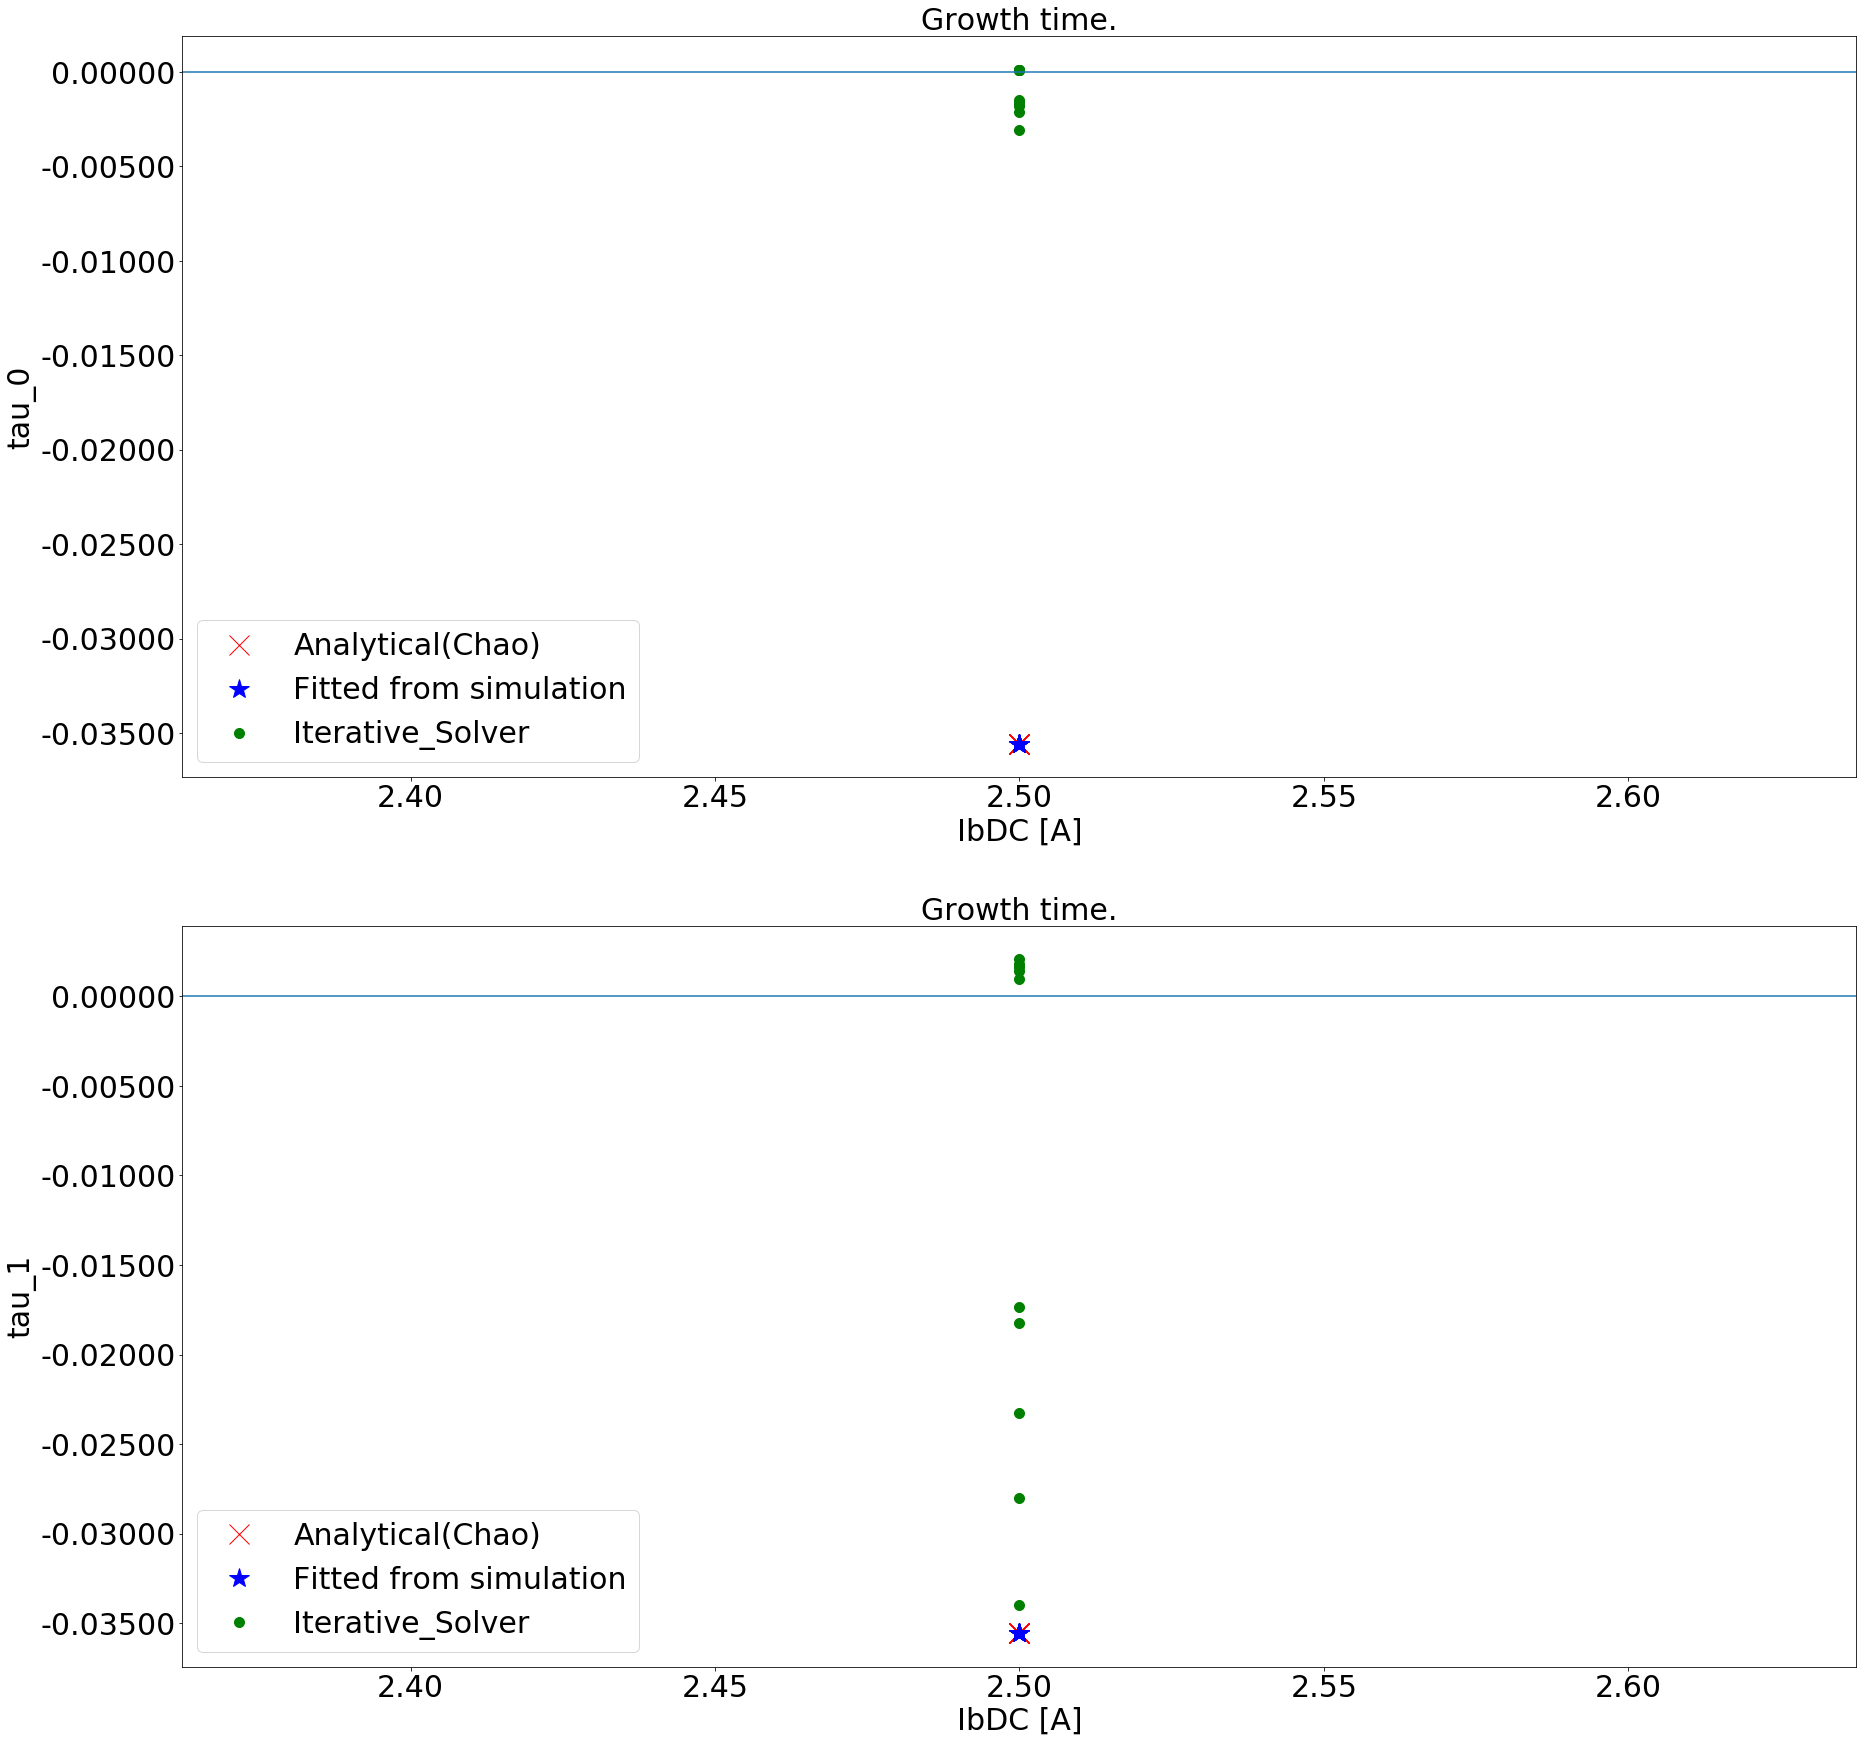

In [49]:
# plot the growth Time vs Ib
os.chdir(home1)
cwd = os.getcwd()
#current = [float(folder[21:25]) for folder in folders]
fig1,axes1 = plt.subplots(N_mode,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
for mu in mus:
    axes1[mu].plot(current[rng1:rng2],1/(delta_omega_Im[mu][rng1:rng2]-1/t_rad_long),'rx', ms = 20)
    axes1[mu].plot(current[rng1:rng2],1/(delta_omega_Im_Iter[mu][rng1:rng2]-1/t_rad_long),'b*', ms = 20)
    axes1[mu].plot(current[rng1:rng2],1/(qs[mu][rng1:rng2]/T0),'g.', ms = 20)
    axes1[mu].axhline(y=0)

    axes1[mu].set_title('Growth time.',fontsize=30)
    axes1[mu].set_ylabel('tau_'+str(mu),fontsize=30)
    axes1[mu].set_xlabel('IbDC [A]',fontsize=30)
    axes1[mu].legend(["Analytical(Chao)","Fitted from simulation", "Iterative_Solver"],prop={'size': 30})
    axes1[mu].tick_params(labelsize=30)
    #axes1.set_ylim([-0.001,0.001])
    y_labels = axes1[mu].get_yticks()
    axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

0001nmacro1_nBin33_Idc2.50A_ThetaL-4.0degree


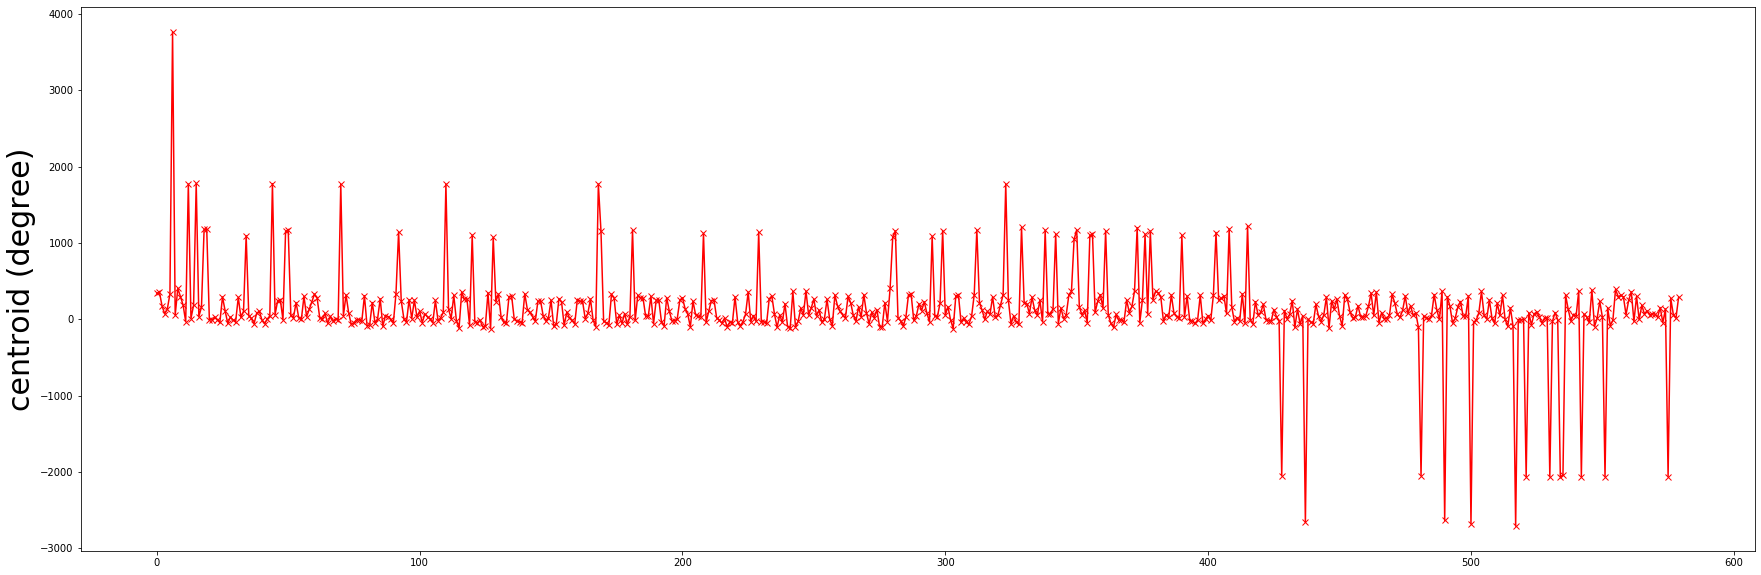

0002nmacro1_nBin33_Idc2.50A_ThetaL-3.0degree


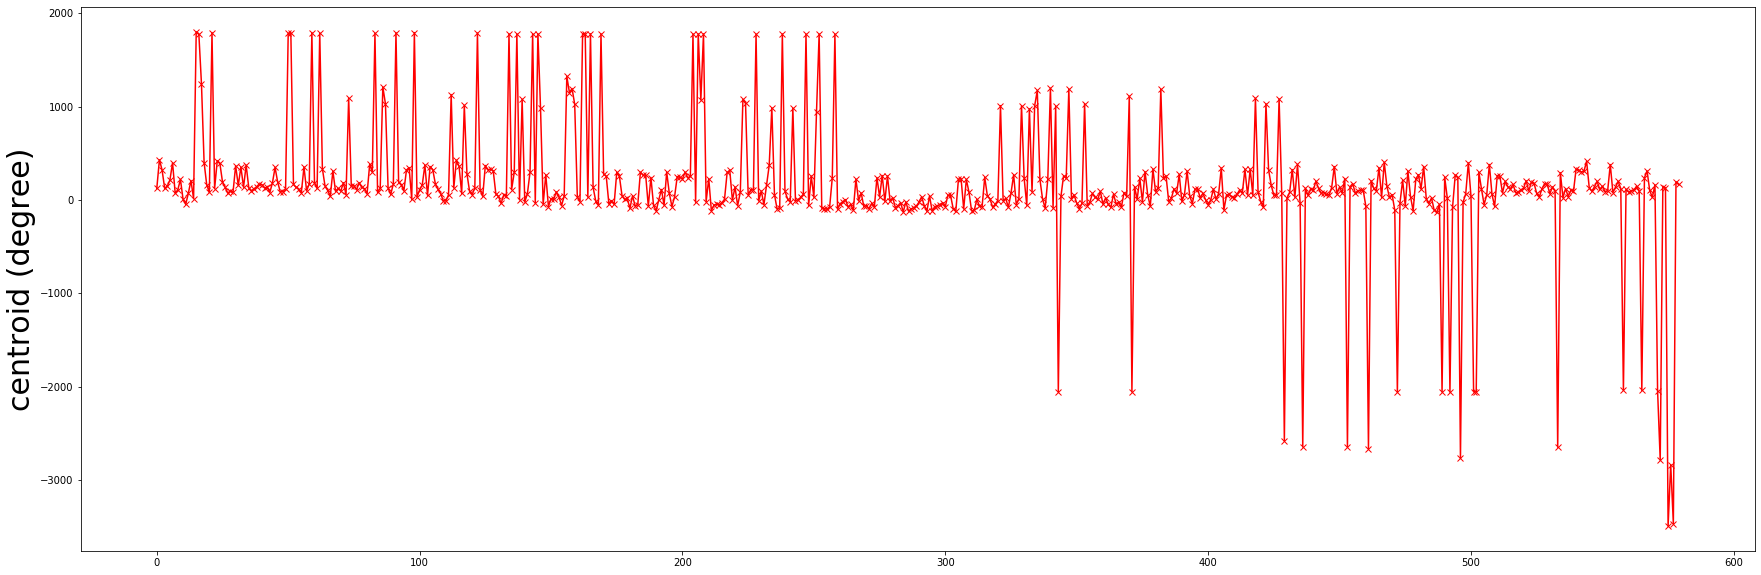

0003nmacro1_nBin33_Idc2.50A_ThetaL-2.0degree


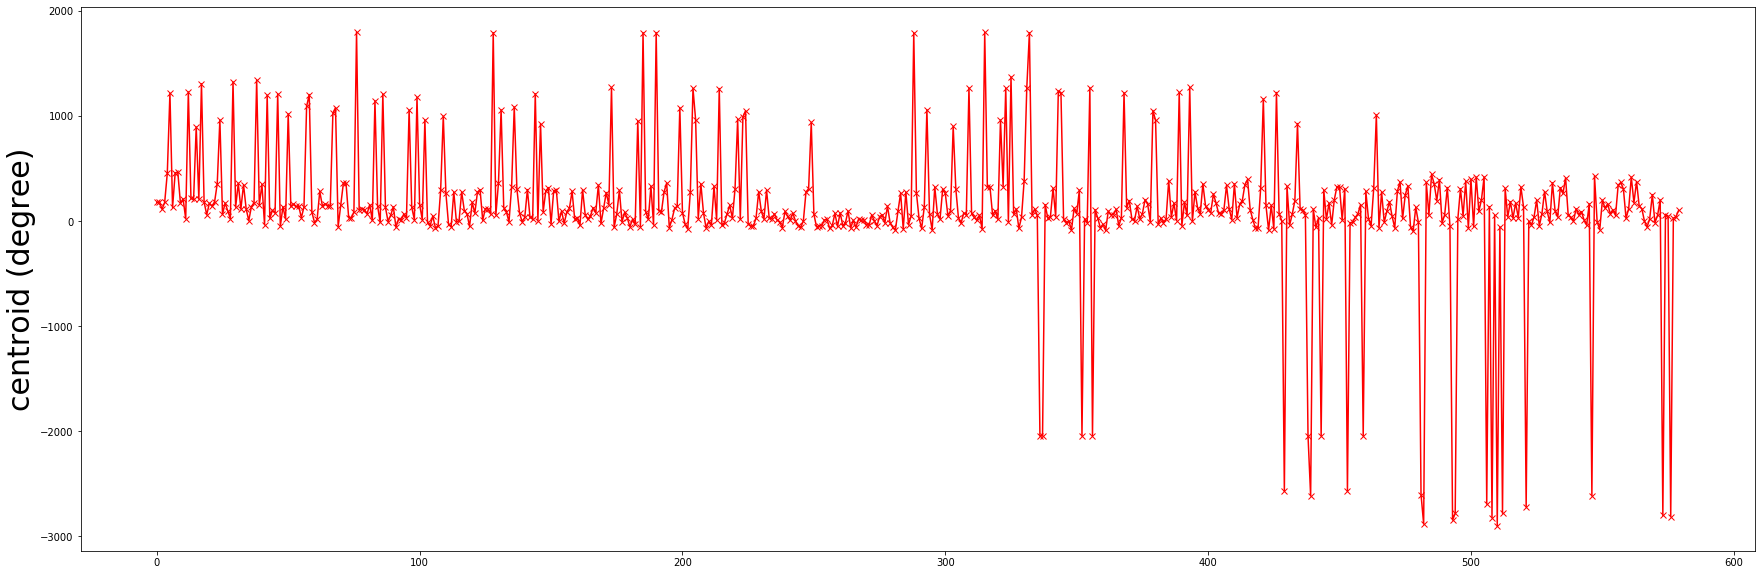

0004nmacro1_nBin33_Idc2.50A_ThetaL-1.0degree


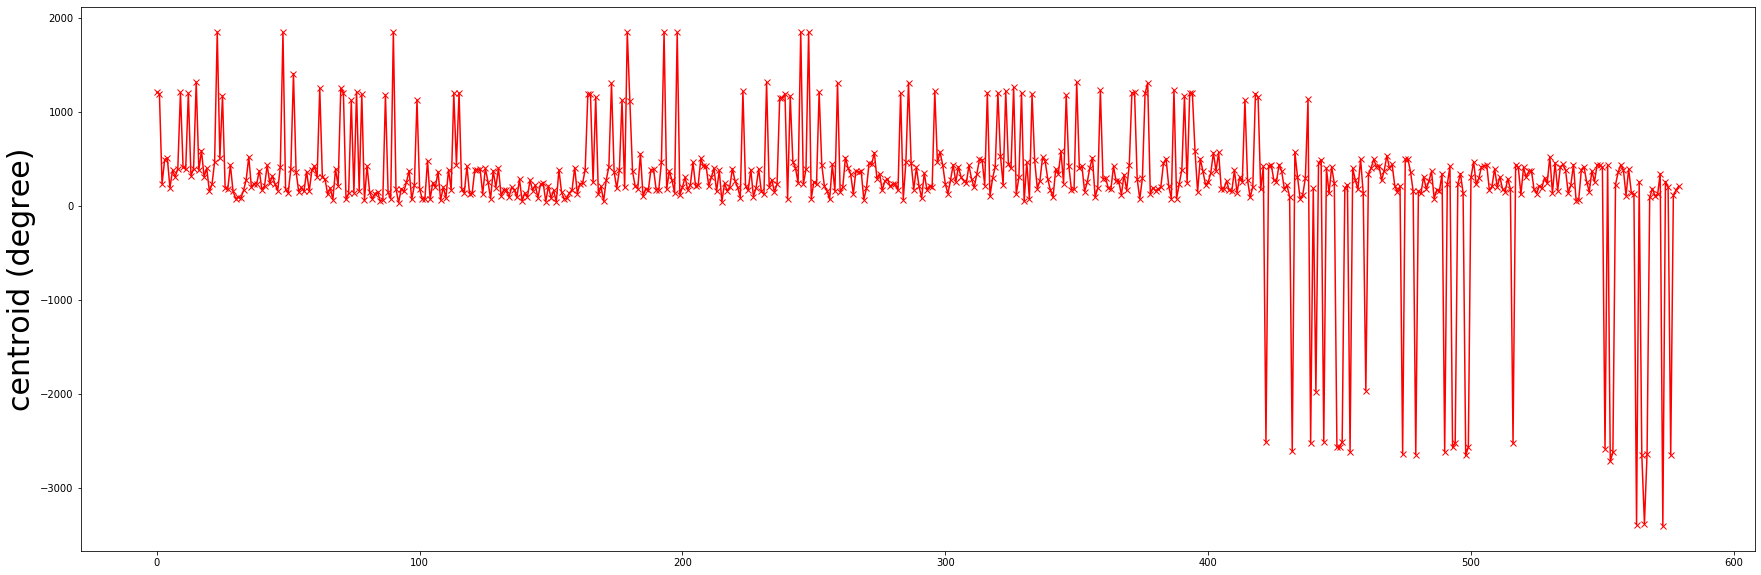

0005nmacro1_nBin33_Idc2.50A_ThetaL0.0degree


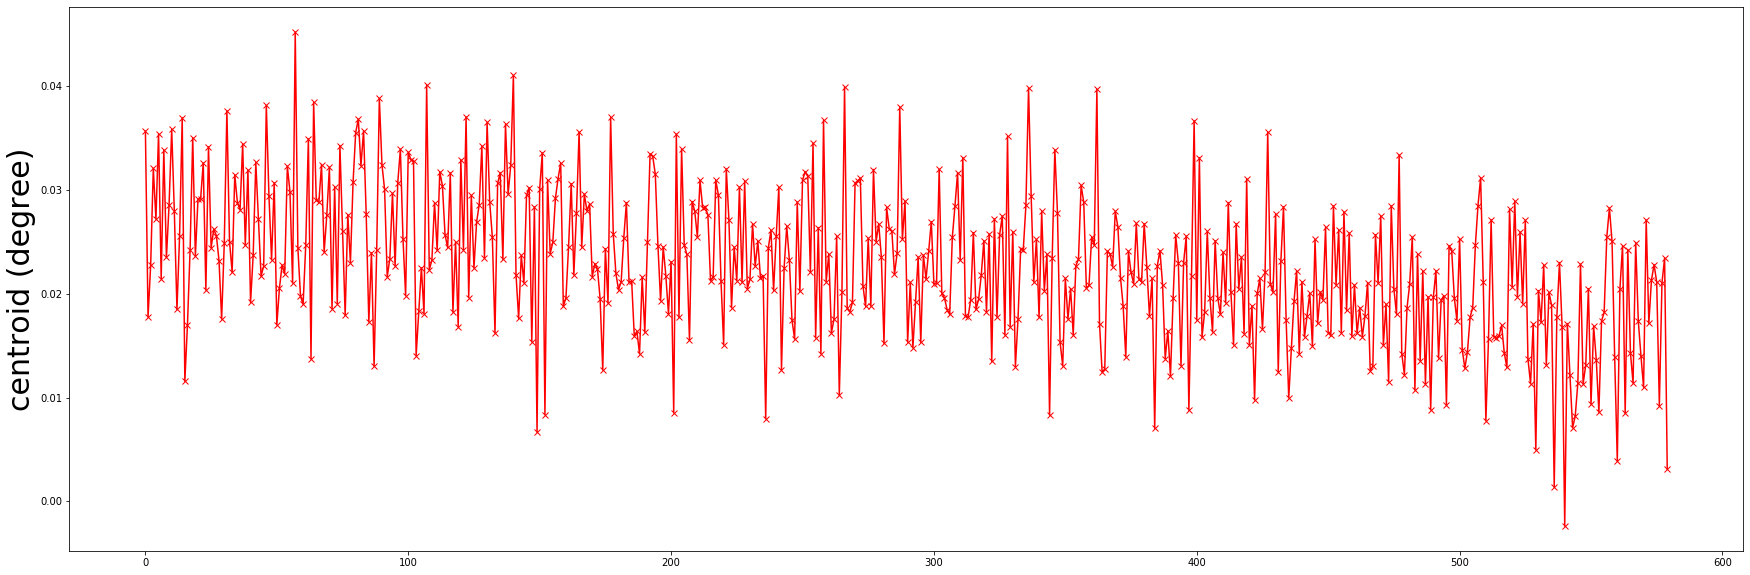

0006nmacro1_nBin33_Idc2.50A_ThetaL1.0degree


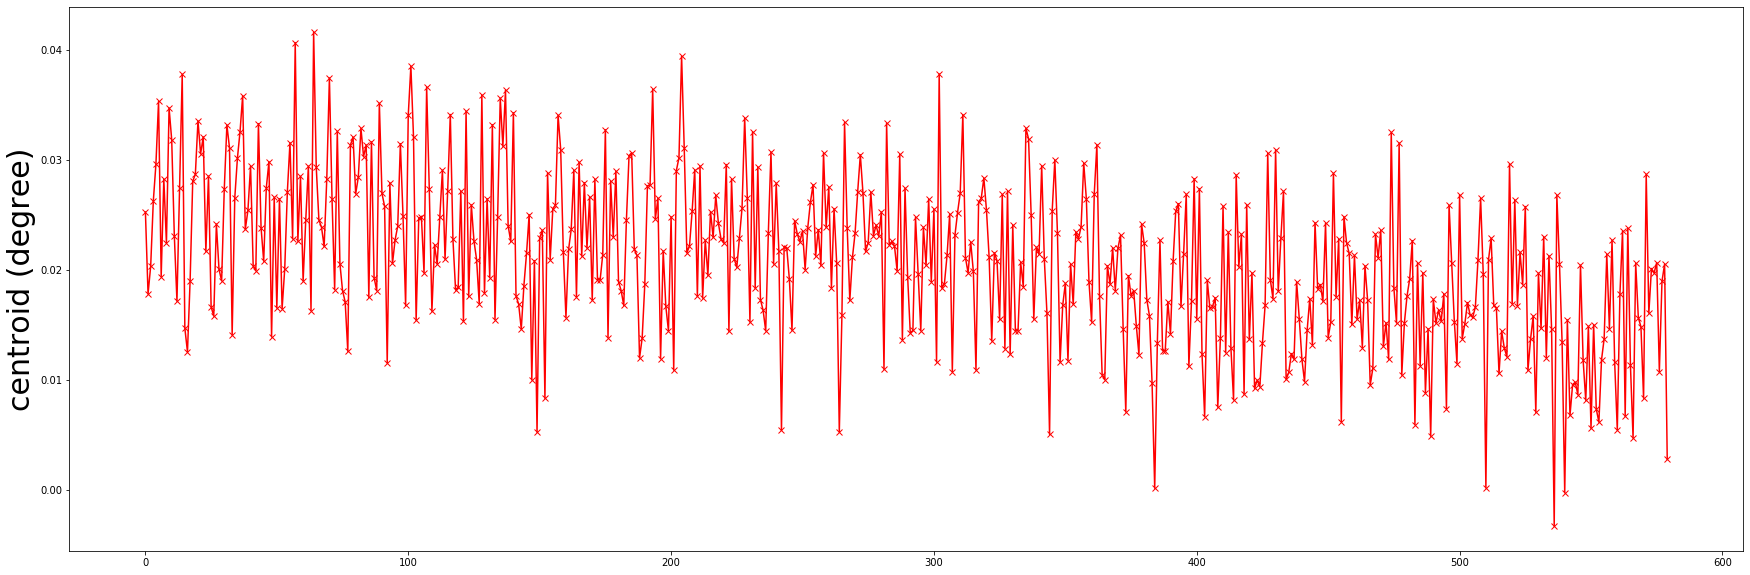

0007nmacro1_nBin33_Idc2.50A_ThetaL2.0degree


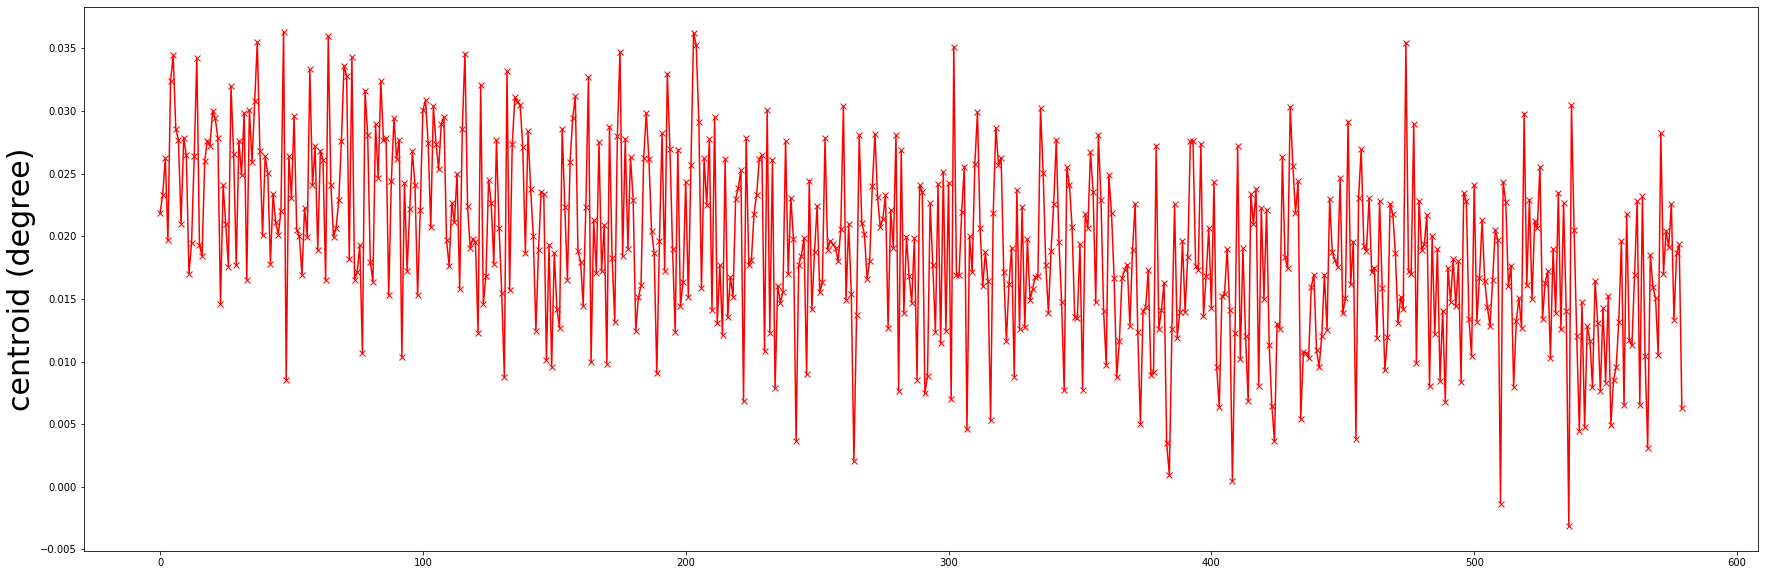

0008nmacro1_nBin33_Idc2.50A_ThetaL3.0degree


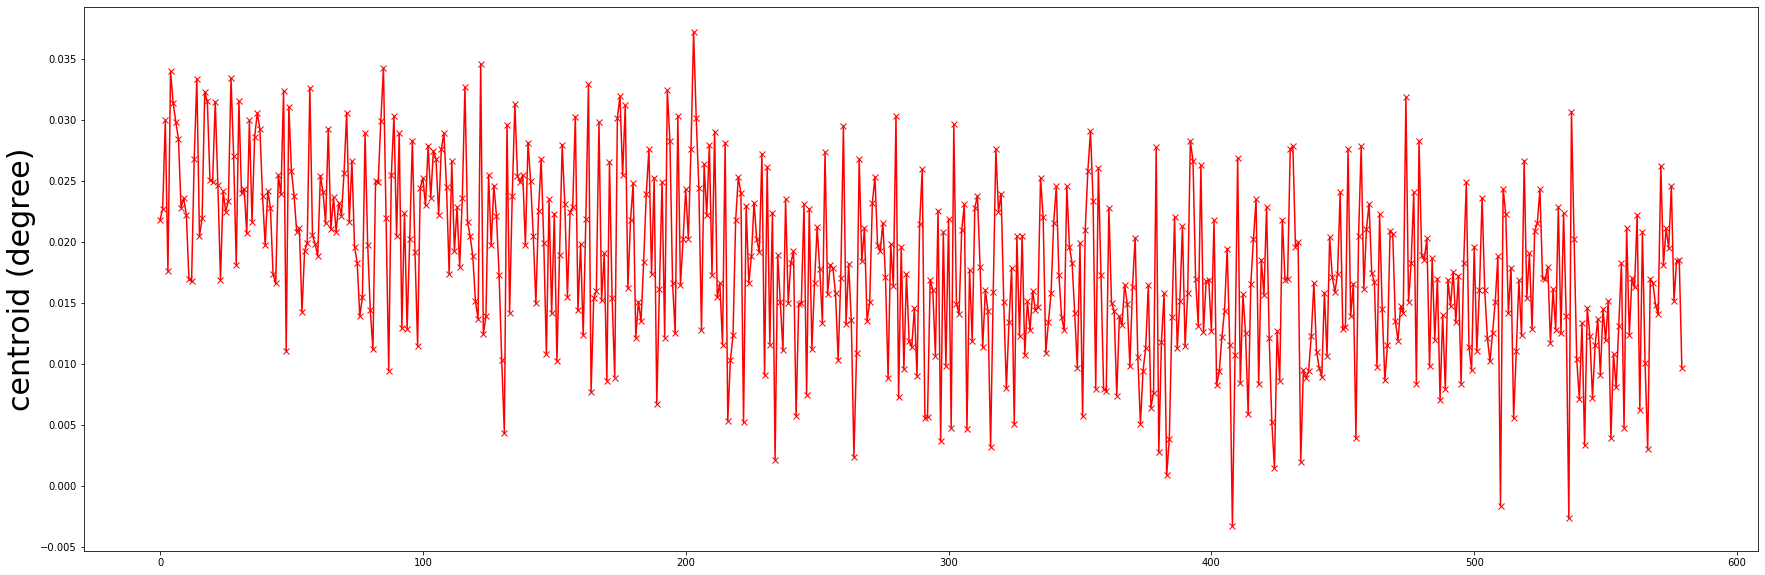

0009nmacro1_nBin33_Idc2.50A_ThetaL4.0degree


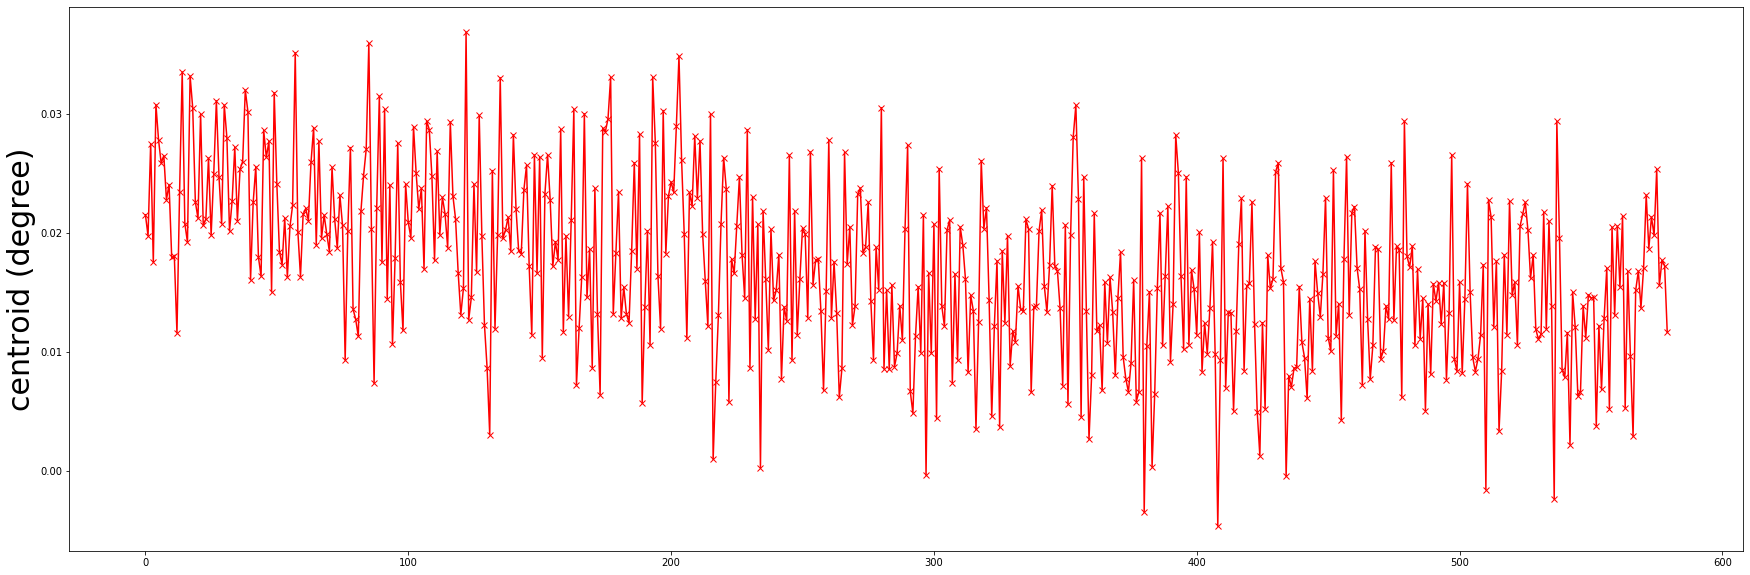

In [50]:
# Plot Centroids
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]

inputfn = 'input.txt'
for folder in new_folders[1:]:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
   
    nTurns = int(tempinput['n_turns'][0])
    
    nBunch = int(tempinput['n_bunches'][0])
    
    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])

    
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    turns = 6000
    rng1 = turns*nBunch
    rng2 = rng1+nBunch
    axes1.plot((np.array(M1_1[rng1:rng2])-centroids)*clight,'rx-')
    
    axes1.set_ylabel('centroid (degree)',fontsize=30)
    fn_after = os.path.join(cwd,'Centroids.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)

0000nmacro1_nBin33_Idc2.50A_ThetaL-5.0degree
Tot data  34800000


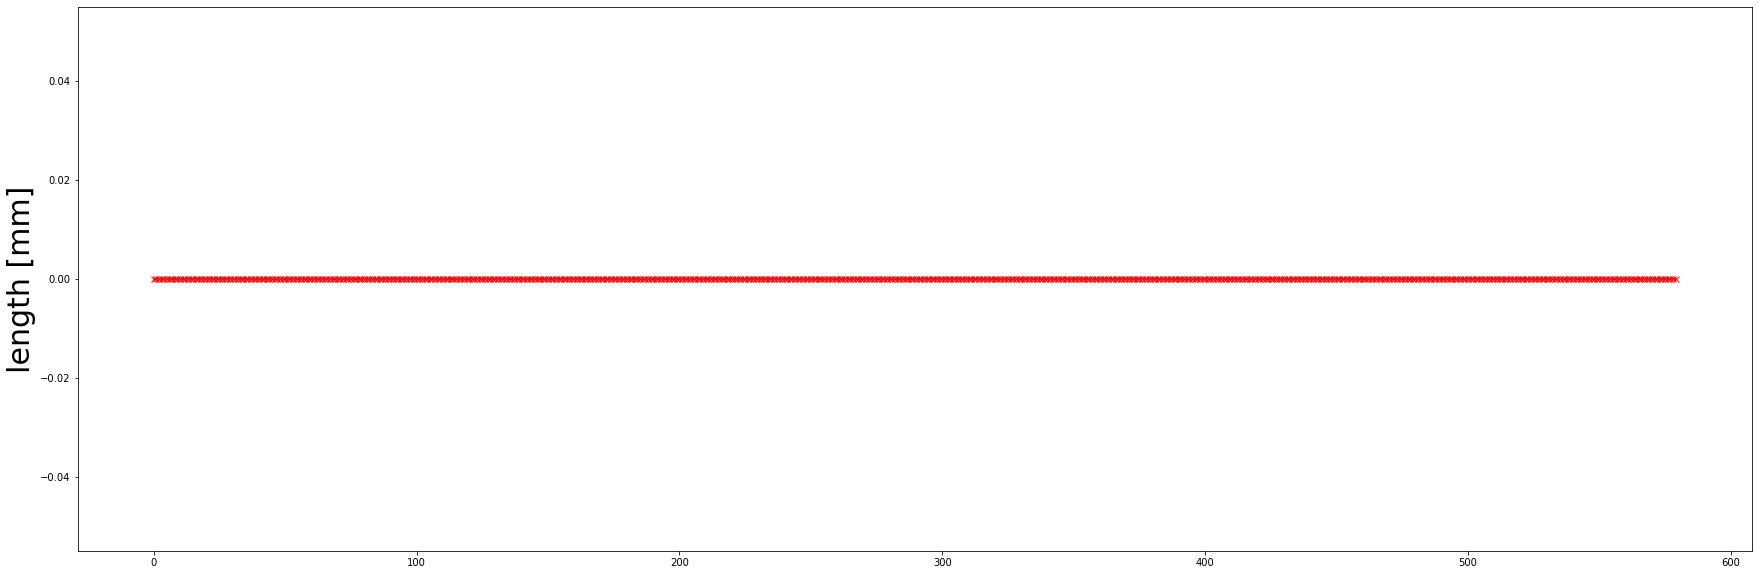

0001nmacro1_nBin33_Idc2.50A_ThetaL-4.0degree
Tot data  34800000


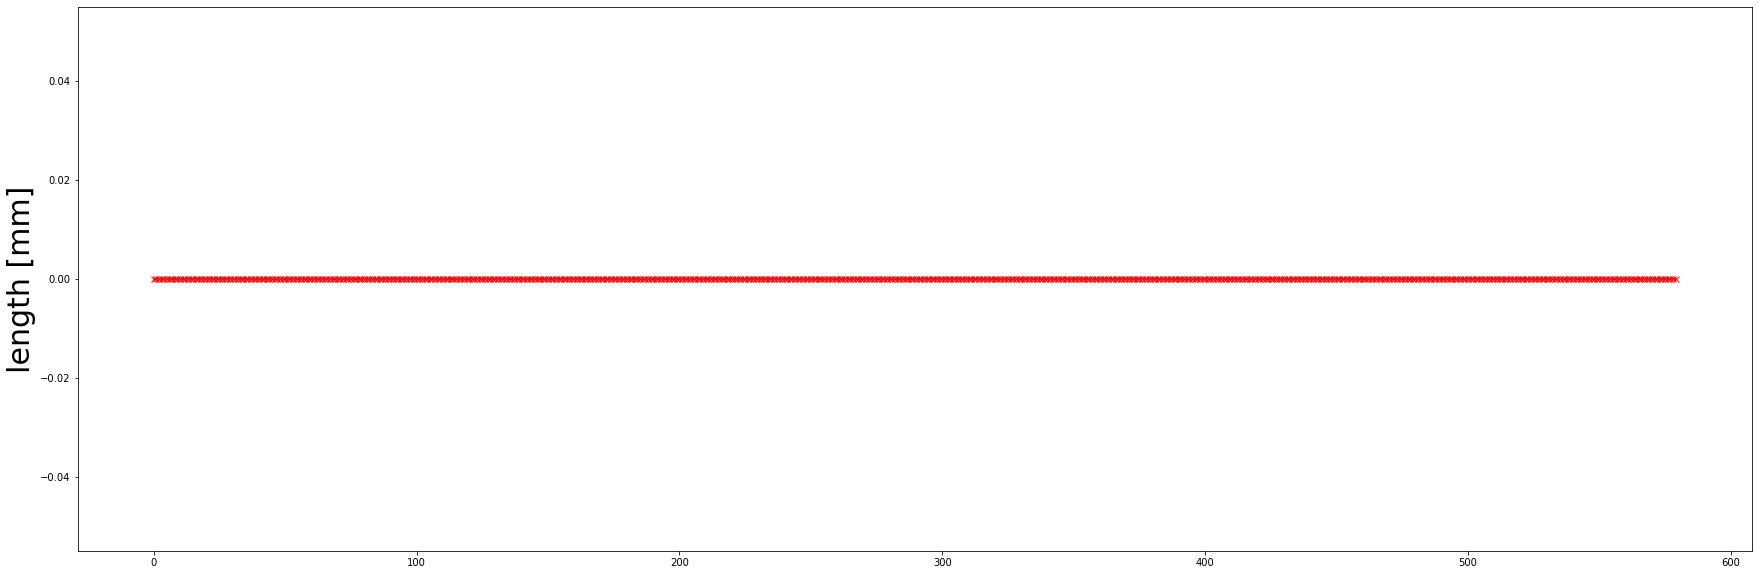

0002nmacro1_nBin33_Idc2.50A_ThetaL-3.0degree
Tot data  34800000


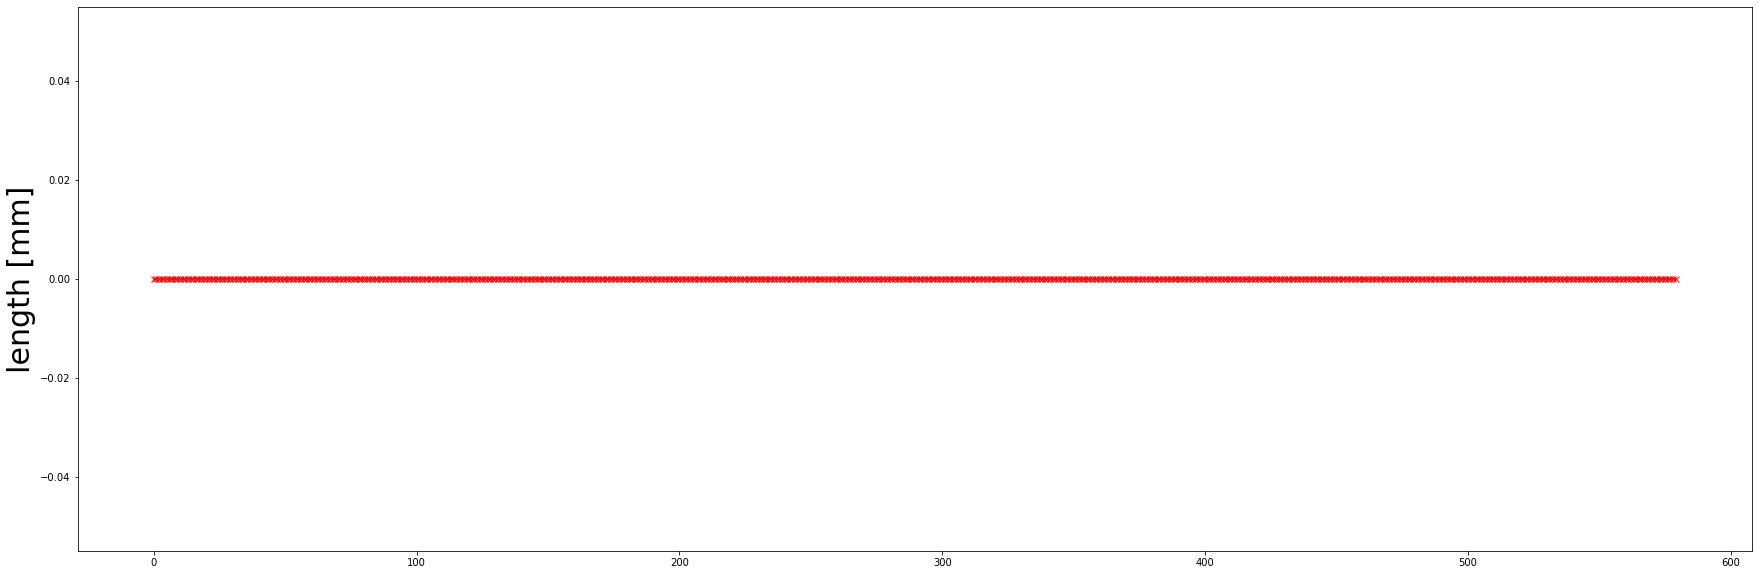

0003nmacro1_nBin33_Idc2.50A_ThetaL-2.0degree
Tot data  34800000


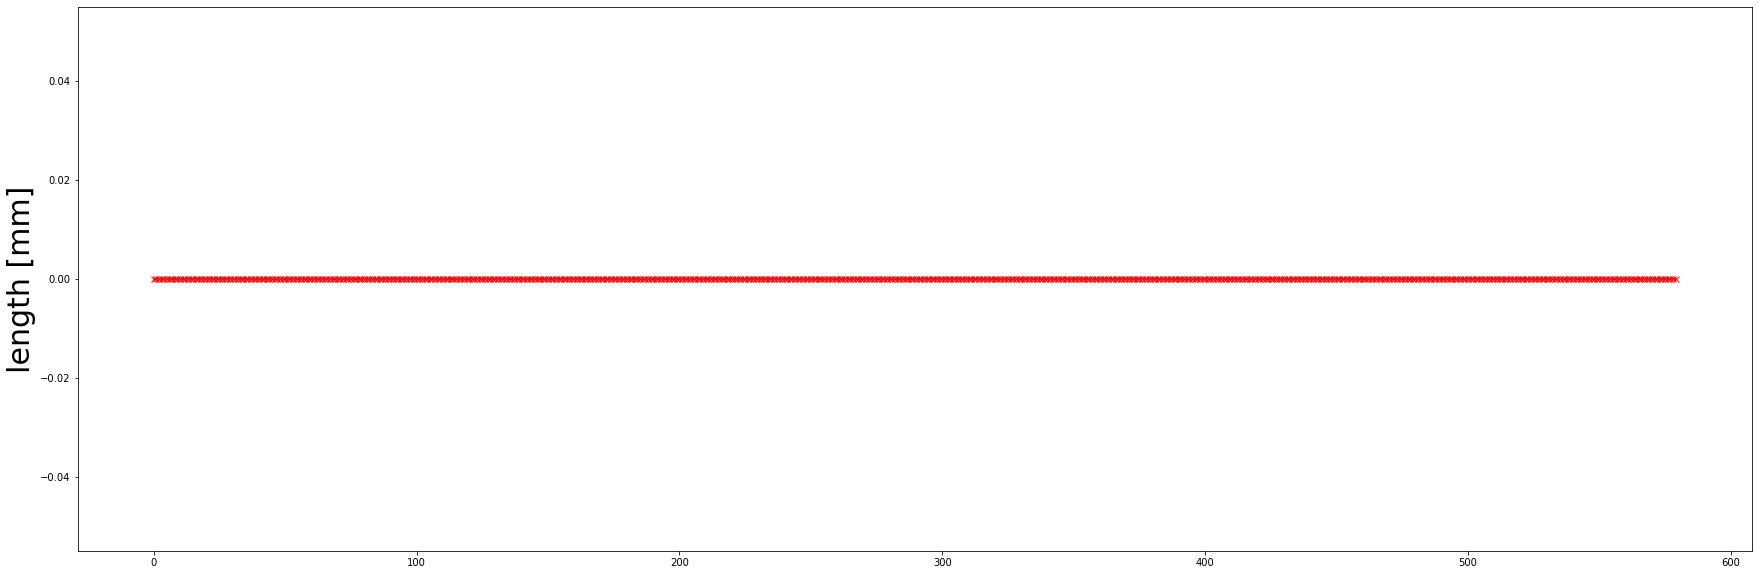

0004nmacro1_nBin33_Idc2.50A_ThetaL-1.0degree
Tot data  34800000


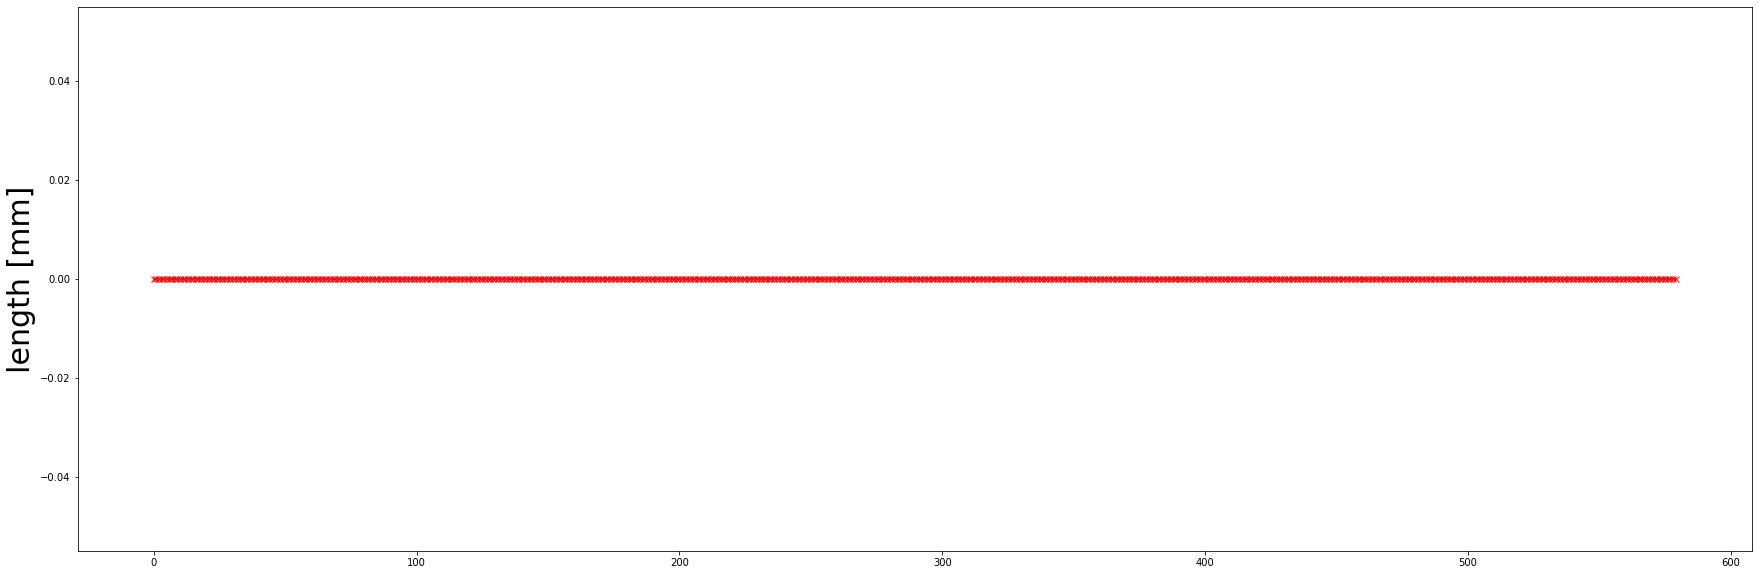

0005nmacro1_nBin33_Idc2.50A_ThetaL0.0degree
Tot data  34800000


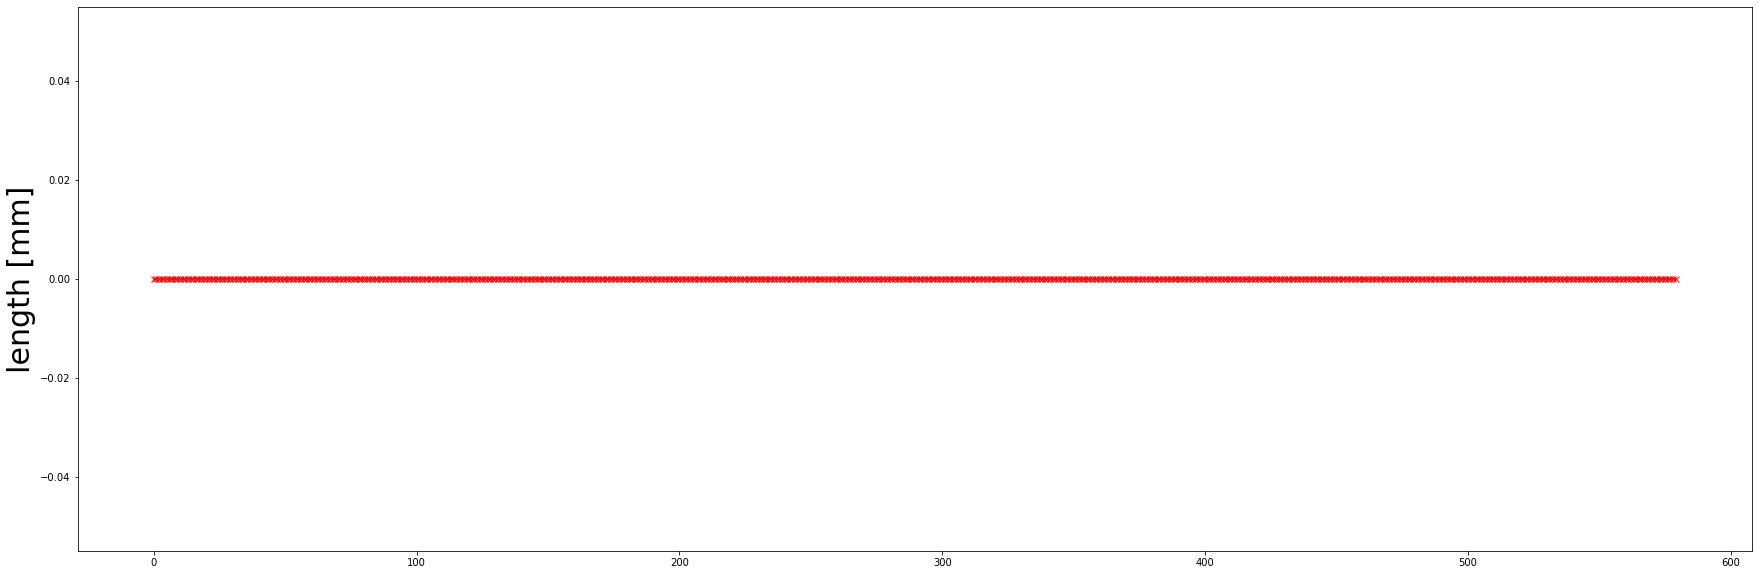

0006nmacro1_nBin33_Idc2.50A_ThetaL1.0degree
Tot data  34800000


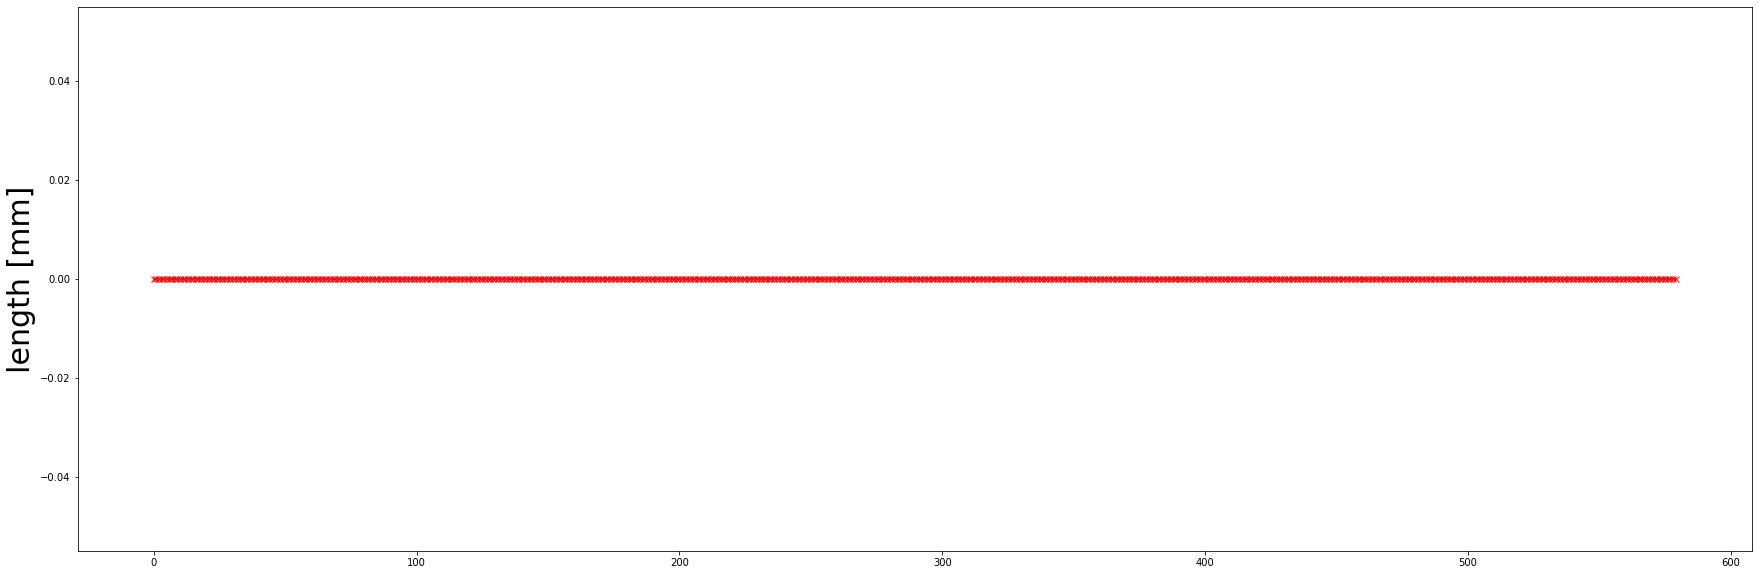

0007nmacro1_nBin33_Idc2.50A_ThetaL2.0degree
Tot data  34800000


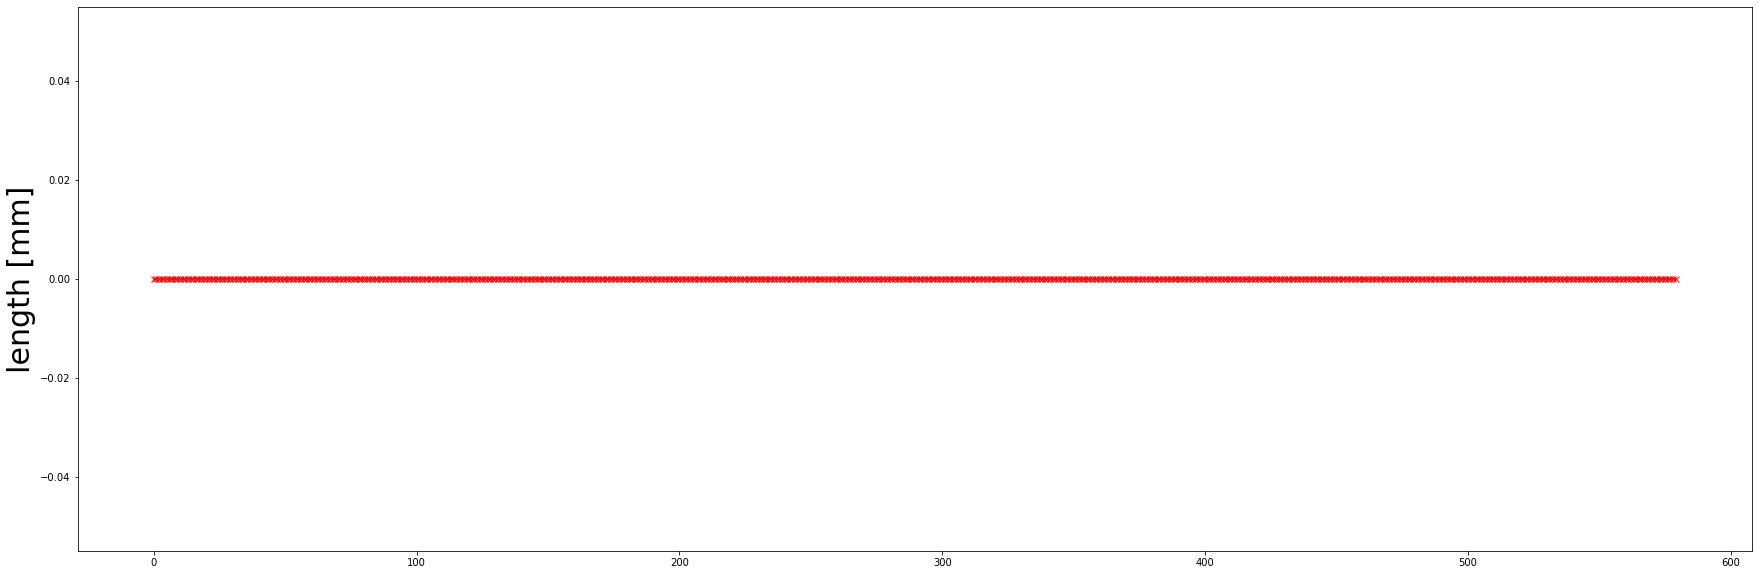

0008nmacro1_nBin33_Idc2.50A_ThetaL3.0degree
Tot data  34800000


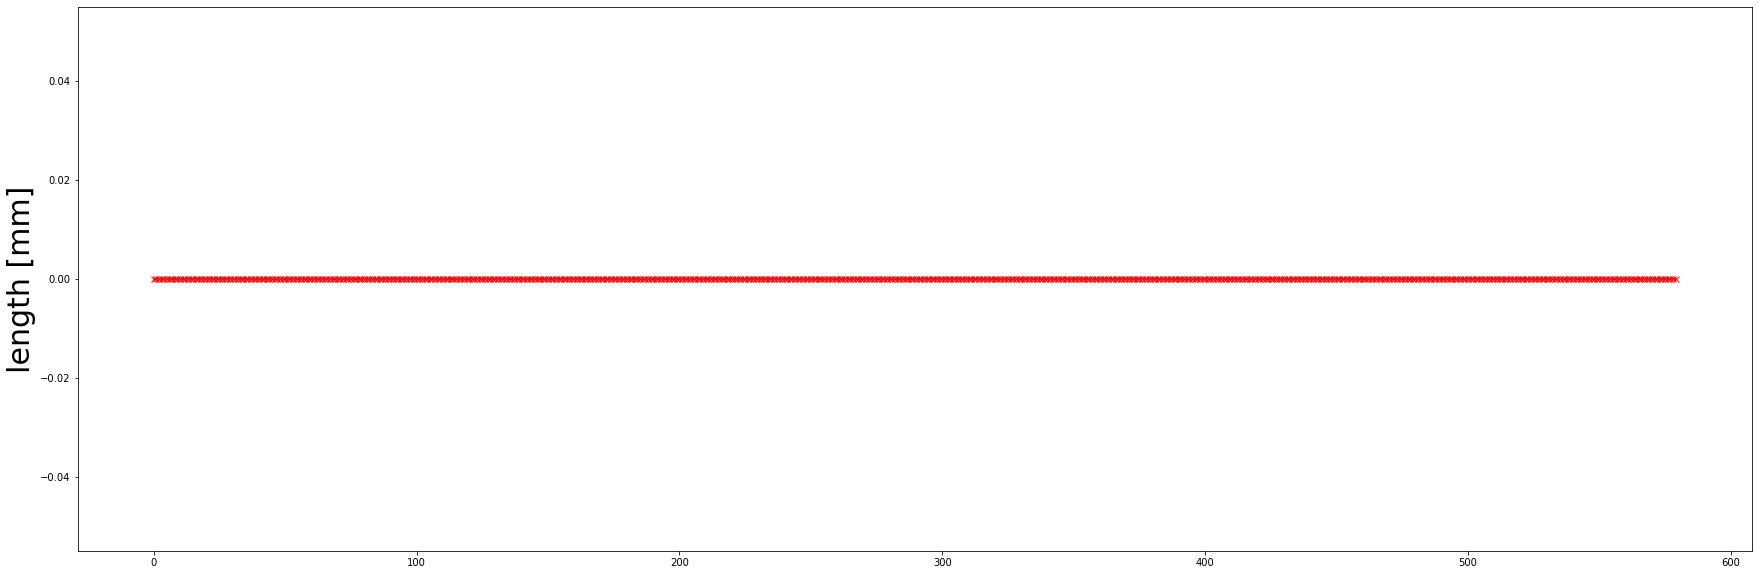

0009nmacro1_nBin33_Idc2.50A_ThetaL4.0degree
Tot data  34800000


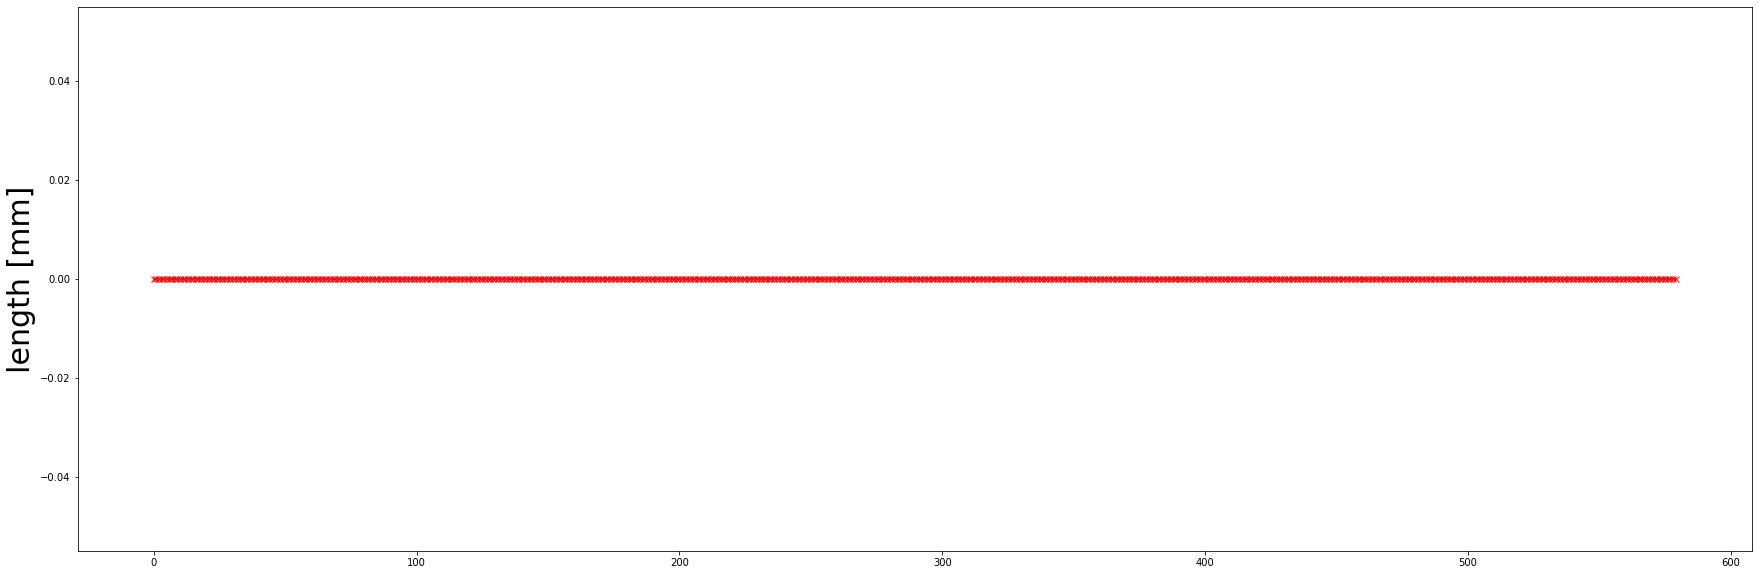

In [51]:
# Plot lengthes
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]

for folder in new_folders:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
   
    nTurns = int(tempinput['n_turns'][0])
    
    nBunch = int(tempinput['n_bunches'][0])
    
    M2_all = array('d')
    M2_fn = 'M2_all.bin'
    datafile = os.path.join(cwd,M2_fn)    
    print("Tot data ",3*nTurns*nBeam*nBunch)
    with open(datafile, mode='rb') as file: # b is important -> binary
        M2_all.fromfile(file,3*nTurns*nBeam*nBunch)
    M2_1 = []
    M2_2 = []
    M2_3 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M2_1.append(M2_all[i*nBunch*3+j])
            M2_2.append(M2_all[i*nBunch*3+nBunch+j])
            M2_3.append(M2_all[i*nBunch*3+nBunch*2+j])
    M2_1 = np.sqrt(np.array(M2_1))*clight*1000
    #M2_2 = np.sqrt(np.array(M2_2))
    #M2_3 = np.sqrt(np.array(M2_3))
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])

    
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    
    turns = 4600
    rng1 = turns*nBunch
    rng2 = rng1+nBunch
    axes1.plot(np.array(M2_1[rng1:rng2]),'rx-')
    
    axes1.set_ylabel('length [mm]',fontsize=30)
    fn_after = os.path.join(cwd,'length.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)